In [370]:
#load packages
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
import datetime as dt
import os
import pytensor.tensor as pt
import matplotlib.patches as mpatches


In [371]:
# get the parent directory
cpath = os.path.dirname(os.getcwd()) # 项目根路径或你保存数据的根路径

experiments = ['Baseline', 'Encoding', 'Reproduction', 'Both','Both_gap'] #, 
#'NULL', 'NoiseInVariance', 'NoiseInMean', 'NoiseInEncoding', 'NoiseInReproduction', 
models = ['NULL', 'EncodingOnly','ReproductionOnly', 'VarianceOnly', 'FreeParameters','Experimentwise']  
MODEL_PATH = os.path.join(cpath, 'data')
OUTPUT_PATH = os.path.join(MODEL_PATH, 'model_comparison_results')


In [372]:
def check_model_reliability(traces_dict, ic='loo', pareto_k_thresh=0.7, warning_p_thresh=0.4):
    """
    对一组模型的 ArviZ InferenceData 进行信息准则比较，并标记可靠性。

    Parameters
    ----------
    traces_dict : dict
        {model_name: InferenceData}，每个模型的 trace
    ic : str
        'loo' 或 'waic'
    pareto_k_thresh : float
        LOO 中 Pareto k 的阈值，超过此值认为不可靠
    warning_p_thresh : float
        WAIC 中 p_waic / var(log_likelihood) 的异常阈值，可自定义

    Returns
    -------
    compare_df : pd.DataFrame
        ArviZ compare 结果，增加列 'reliable' (True/False)
    """
    # 先尝试计算信息准则
    try:
        compare_df = az.compare(traces_dict, ic=ic, scale='deviance')
    except Exception as e:
        print(f"Error computing {ic}: {e}")
        return None

    # 初始化可靠性标记
    compare_df['reliable'] = True

    # LOO 可靠性检查
    if ic.lower() == 'loo':
        for name, idata in traces_dict.items():
            loo = az.loo(idata)
            if np.any(loo.pareto_k > pareto_k_thresh):
                # Pareto k 大于阈值，不可靠
                compare_df.loc[name, 'reliable'] = False
                print(f"LOO warning: {name} has Pareto k > {pareto_k_thresh}")

    # WAIC 可靠性检查
    elif ic.lower() == 'waic':
        for name, idata in traces_dict.items():
            try:
                waic = az.waic(idata)
                # 如果 warning=True 或 p_waic 太大，则标记不可靠
                if getattr(waic, 'warning', False) or (waic.p_waic / np.var(idata.log_likelihood.to_array())) > warning_p_thresh:
                    compare_df.loc[name, 'reliable'] = False
                    print(f"WAIC warning: {name} may be unreliable")
            except Exception as e:
                compare_df.loc[name, 'reliable'] = False
                print(f"WAIC check failed for {name}: {e}")

    # 返回增加了 'reliable' 标记的 compare_df
    return compare_df

In [373]:
# -----------------------------
# 存放各实验比较结果
# -----------------------------
all_compare_results = {"loo": {}, "waic": {}, "ppc_mse": {}}

for exp in experiments:
    print(f"\n=== Comparing models for experiment: {exp} ===")
    all_compare_results["loo"][exp] = {}
    all_compare_results["waic"][exp] = {}
    all_compare_results["ppc_mse"][exp] = {}

    traces = {}

    # -----------------------------
    # 加载每个模型（不拆模型名）
    # -----------------------------
    for m in models:
        # 直接用模型名作为文件夹名
        trace_file = os.path.join(MODEL_PATH, m, f"{exp}_trace.nc")

        if os.path.exists(trace_file):
            try:
                traces[m] = az.from_netcdf(trace_file)
                print(f"   Loaded: {trace_file}")
            except Exception as e:
                print(f"  Failed to load {trace_file}: {e}")
        else:
            print(f"   Missing: {trace_file}")

    # -----------------------------
    # 至少两个模型才能比较
    # -----------------------------
    if len(traces) < 2:
        print(f"   Not enough models for {exp}, skipping…")
        continue

    # -----------------------------
    # LOO 比较
    # -----------------------------
    try:
        compare_loo = az.compare(traces, ic="loo", scale="deviance")
        out_loo = os.path.join(OUTPUT_PATH, f"{exp}_loo_comparison.csv")
        compare_loo.to_csv(out_loo)
        all_compare_results["loo"][exp] = compare_loo
        print(f"  LOO saved: {out_loo}")
    except Exception as e:
        print(f"   LOO comparison failed: {e}")

    # -----------------------------
    # WAIC 比较
    # -----------------------------
    try:
        compare_waic = az.compare(traces, ic="waic", scale="deviance")
        out_waic = os.path.join(OUTPUT_PATH, f"{exp}_waic_comparison.csv")
        compare_waic.to_csv(out_waic)
        all_compare_results["waic"][exp] = compare_waic
        print(f"  WAIC saved: {out_waic}")
    except Exception as e:
        print(f"  WAIC comparison failed: {e}")



=== Comparing models for experiment: Baseline ===
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/NULL/Baseline_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/EncodingOnly/Baseline_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/ReproductionOnly/Baseline_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/VarianceOnly/Baseline_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/FreeParameters/Baseline_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/Experimentwise/Baseline_trace.nc


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-pac

  LOO saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/Baseline_loo_comparison.csv


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:

  WAIC saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/Baseline_waic_comparison.csv

=== Comparing models for experiment: Encoding ===
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/NULL/Encoding_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/EncodingOnly/Encoding_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/ReproductionOnly/Encoding_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/VarianceOnly/Encoding_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/FreeParameters/Encoding_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/Experimentwise/Encoding_trace.nc
  LOO saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/Encoding_loo_comparison.csv


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:

  WAIC saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/Encoding_waic_comparison.csv

=== Comparing models for experiment: Reproduction ===
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/NULL/Reproduction_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/EncodingOnly/Reproduction_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/ReproductionOnly/Reproduction_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/VarianceOnly/Reproduction_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/FreeParameters/Reproduction_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/Experimentwise/Reproduction_trace.nc


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-pac

  LOO saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/Reproduction_loo_comparison.csv


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:

  WAIC saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/Reproduction_waic_comparison.csv

=== Comparing models for experiment: Both ===
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/NULL/Both_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/EncodingOnly/Both_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/ReproductionOnly/Both_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/VarianceOnly/Both_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/FreeParameters/Both_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/Experimentwise/Both_trace.nc


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-pac

  LOO saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/Both_loo_comparison.csv


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:

  WAIC saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/Both_waic_comparison.csv

=== Comparing models for experiment: Both_gap ===
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/NULL/Both_gap_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/EncodingOnly/Both_gap_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/ReproductionOnly/Both_gap_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/VarianceOnly/Both_gap_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/FreeParameters/Both_gap_trace.nc
   Loaded: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/Experimentwise/Both_gap_trace.nc
  LOO saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/Both_gap_loo_comparison.csv


/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/fionazhu/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:

  WAIC saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/Both_gap_waic_comparison.csv


In [374]:
#import pickle

#with open(os.path.join(OUTPUT_PATH, "all_compare_results.pkl"), "wb") as f:
#    pickle.dump(all_compare_results, f)

In [375]:
#import pickle

#with open(os.path.join(OUTPUT_PATH, "all_compare_results.pkl"), "rb") as f:
#    all_compare_results = pickle.load(f)

In [380]:
def summarize_and_find_best(all_compare_results, output_path):
    records = []

    # 遍历 ic_type
    for ic_type in ['loo', 'waic']:
        for exp, df in all_compare_results[ic_type].items():
            if not isinstance(df, pd.DataFrame) or df.empty:
                continue
            tmp = df.copy()
            tmp['experiment'] = exp
            tmp['ic_type'] = ic_type
            tmp['model_full'] = tmp.index
            # 计算 d_ic
            tmp['d_ic'] = tmp['elpd_diff'].fillna(0)  # elpd_diff 就可以用
            records.append(tmp.reset_index(drop=True))

    summary = pd.concat(records, ignore_index=True, sort=False)

    # ---- 找每个实验最佳模型 ----
    best_rows = []
    for (exp, ic), grp in summary.groupby(['experiment', 'ic_type']):
        # 最小 d_ic 对应最好
        idx_best = grp['d_ic'].idxmin()
        best_model_d_ic = grp.loc[idx_best, 'd_ic']

        grp['delta_ic'] = grp['d_ic'] - best_model_d_ic  # ΔLOO / ΔWAIC
        summary.loc[grp.index, 'delta_ic'] = grp['delta_ic']

        best_rows.append({
            'experiment': exp,
            'ic_type': ic,
            'best_model': grp.loc[idx_best, 'model_full'],
            'best_d_ic': best_model_d_ic
        })

    best_df = pd.DataFrame(best_rows)

    # ---- 保存 CSV ----
    summary_csv = os.path.join(output_path, 'all_models_with_delta.csv')
    best_csv = os.path.join(output_path, 'best_model_per_experiment.csv')
    summary.to_csv(summary_csv, index=False)
    best_df.to_csv(best_csv, index=False)

    print(f"✅ Saved all models with ΔIC: {summary_csv}")
    print(f"✅ Saved best model per experiment: {best_csv}")

    return summary, best_df


In [381]:
def compute_model_ic_summary(summary):
    """
    汇总每个模型的平均 LOO / WAIC 以及平均 ΔIC（elpd_diff）
    """
    df = summary.copy()

    # 提取有效 IC 行（LOO + WAIC）
    df = df[df['ic_type'].isin(['loo', 'waic'])]

    # 自动选择 IC 数值字段
    ic_value_map = {
        'loo': 'elpd_loo',
        'waic': 'elpd_waic'
    }

    # 检查字段是否存在
    for ic, col in ic_value_map.items():
        if col not in df.columns:
            raise ValueError(f"缺少字段 {col}，请检查 summary 结构。")

    # 生成统一列 ic_value
    df["ic_value"] = df.apply(lambda row: row[ic_value_map[row["ic_type"]]], axis=1)

    # 汇总
    table = (
        df.groupby(["model_full", "ic_type"])
          .agg(
              mean_ic=("ic_value", "mean"),
              mean_delta=("elpd_diff", "mean")
          )
          .reset_index()
          .pivot(index="model_full", columns="ic_type")
    )

    # 展开列名（生成 loo_mean_ic / waic_mean_ic / loo_mean_delta 等）
    table.columns = [f"{ic}_{stat}" for stat, ic in table.columns]

    # 按你论文模型顺序排序
    model_order = [
        'NULL', 'EncodingOnly', 'ReproductionOnly', 'FreeParameters', 'Experimentwise'
    ]

    table = table.reindex(model_order)

    return table


table_df = compute_model_ic_summary(summary)
print(table_df)


                  loo_mean_ic  waic_mean_ic  loo_mean_delta  waic_mean_delta
model_full                                                                  
NULL             -2239.396469  -2240.331017      153.780622       153.551512
EncodingOnly     -2370.606420  -2371.363623       22.570671        22.518906
ReproductionOnly -2237.478789  -2238.204488      155.698302       155.678041
FreeParameters   -2388.672211  -2389.588417        4.504880         4.294112
Experimentwise   -2393.171282  -2393.882529        0.005809         0.000000


In [382]:
print(summary.columns)

Index(['rank', 'elpd_loo', 'p_loo', 'elpd_diff', 'weight', 'se', 'dse',
       'warning', 'scale', 'experiment', 'ic_type', 'model_full', 'model',
       'setting', 'elpd_waic', 'p_waic', 'significant'],
      dtype='object')


In [383]:
# 1️⃣ 汇总每个实验的模型比较结果，计算 ΔLOO / ΔWAIC
summary_df, best_df = summarize_and_find_best(all_compare_results, OUTPUT_PATH)

# summary_df: 每个模型每个实验的 ΔIC
# best_df: 每个实验的最佳模型
print("\n=== Summary with ΔIC ===")
print(summary_df)


✅ Saved all models with ΔIC: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/all_models_with_delta.csv
✅ Saved best model per experiment: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/best_model_per_experiment.csv

=== Summary with ΔIC ===
    rank     elpd_loo       p_loo   elpd_diff        weight          se  \
0      0 -2034.807001   80.069323    0.000000  9.097183e-01  157.521751   
1      1 -2029.560401   79.951495    5.246601  1.185172e-15  157.568015   
2      2 -2029.560401   79.951495    5.246601  2.229520e-15  157.568015   
3      3 -2020.564547   86.095852   14.242454  9.028173e-02  156.658586   
4      4 -2017.715221   95.155290   17.091781  2.281865e-16  157.533493   
5      5 -2010.896330   86.300667   23.910671  0.000000e+00  157.574256   
6      0   946.168611   69.556845    0.000000  3.065465e-01  126.771880   
7      1   946.168611   69.556845    0.000000  3.065465e-01  126.771880   
8

In [384]:

print("\n=== Best model per experiment ===")
print(best_df)

# 2️⃣ （可选）计算每个模型在所有实验的平均 ΔLOO / ΔWAIC，并找出整体最佳模型
avg_df, best_avg_df = average_delta_ic_and_best(summary_df, OUTPUT_PATH)

print("\n=== Average ΔIC per model ===")
print(avg_df)

print("\n=== Overall best model per IC type ===")
print(best_avg_df)


=== Best model per experiment ===
     experiment ic_type        best_model  best_d_ic
0      Baseline     loo      VarianceOnly        0.0
1      Baseline    waic      VarianceOnly        0.0
2          Both     loo      EncodingOnly        0.0
3          Both    waic    Experimentwise        0.0
4      Both_gap     loo    Experimentwise        0.0
5      Both_gap    waic    Experimentwise        0.0
6      Encoding     loo      EncodingOnly        0.0
7      Encoding    waic      EncodingOnly        0.0
8  Reproduction     loo  ReproductionOnly        0.0
9  Reproduction    waic  ReproductionOnly        0.0
✅ Saved average ΔIC per model: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/average_delta_ic_per_model.csv
✅ Saved overall best model: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/best_model_overall.csv

=== Average ΔIC per model ===
   ic_type        model_full  mean_delta_ic  mean_weight
0  

In [385]:
def average_delta_ic_and_best(summary, output_path):
    """
    计算每个模型在所有实验的平均 ΔLOO / ΔWAIC，并选出整体最佳模型。
    保存 CSV 到 output_path。
    """
    # 确保 delta_ic 列存在
    if 'delta_ic' not in summary.columns:
        raise ValueError("summary must contain 'delta_ic' column. Run summarize_and_find_best(...) first.")

    # 按 ic_type + model_full 分组计算平均 delta_ic
    avg_df = (
        summary.groupby(['ic_type', 'model_full'], as_index=False)
        .agg(
            mean_delta_ic=('delta_ic', 'mean'),
            mean_weight=('weight', 'mean')
        )
    )

    # 找出每个 ic_type 的最佳模型（最小 mean_delta_ic）
    best_rows = []
    for ic_type, grp in avg_df.groupby('ic_type'):
        idx_best = grp['mean_delta_ic'].idxmin()
        best_model = grp.loc[idx_best, 'model_full']
        best_rows.append({
            'ic_type': ic_type,
            'best_model': best_model,
            'mean_delta_ic': grp.loc[idx_best, 'mean_delta_ic']
        })

    best_avg_df = pd.DataFrame(best_rows)

    # 保存 CSV
    avg_csv = os.path.join(output_path, 'average_delta_ic_per_model.csv')
    best_avg_csv = os.path.join(output_path, 'best_model_overall.csv')
    avg_df.to_csv(avg_csv, index=False)
    best_avg_df.to_csv(best_avg_csv, index=False)

    print(f"✅ Saved average ΔIC per model: {avg_csv}")
    print(f"✅ Saved overall best model: {best_avg_csv}")

    return avg_df, best_avg_df

# Example usage:
avg_df, best_avg_df = average_delta_ic_and_best(summary_df, OUTPUT_PATH)


✅ Saved average ΔIC per model: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/average_delta_ic_per_model.csv
✅ Saved overall best model: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/best_model_overall.csv


In [386]:

def summarize_all_compare_results(all_compare_results, output_path):
    """
    汇总 all_compare_results 中所有实验和指标 (loo, waic, ppc_mse)
    输出一个完整的 DataFrame，并保存为 CSV。
    """
    records = []

    # 1️⃣ LOO 和 WAIC
    for ic_type in ['loo', 'waic']:
        ic_results = all_compare_results.get(ic_type, {})
        for exp, df in ic_results.items():
            if not isinstance(df, pd.DataFrame) or df.empty:
                continue
            df_tmp = df.copy()
            df_tmp["experiment"] = exp
            df_tmp["ic_type"] = ic_type
            df_tmp["model_full"] = df_tmp.index  # 模型名

            # 分离 model / setting（如果有下划线）
            if df_tmp["model_full"].str.contains("_").any():
                parts = df_tmp["model_full"].str.split("_", n=1, expand=True)
                df_tmp["model"] = parts[0]
                df_tmp["setting"] = parts[1]
            else:
                df_tmp["model"] = df_tmp["model_full"]
                df_tmp["setting"] = "NA"

            records.append(df_tmp.reset_index(drop=True))

    # 2️⃣ PPC MSE
    ppc_results = all_compare_results.get("ppc_mse", {})
    for exp, df in ppc_results.items():
        if not isinstance(df, pd.DataFrame) or df.empty:
            continue
        df_tmp = df.copy()
        df_tmp["experiment"] = exp
        df_tmp["ic_type"] = "ppc_mse"
        df_tmp["model_full"] = df_tmp.index
        df_tmp["model"] = df_tmp["model_full"]
        df_tmp["setting"] = "NA"
        # 对齐列名：rank、weight 留空
        df_tmp["rank"] = None
        df_tmp["weight"] = None
        records.append(df_tmp.reset_index(drop=True))

    # 合并所有结果
    if not records:
        print("⚠️ No valid comparison results found.")
        return None

    summary_df = pd.concat(records, ignore_index=True, sort=False)

    # 保存 CSV
    os.makedirs(output_path, exist_ok=True)
    out_csv = os.path.join(output_path, "all_model_comparisons_summary.csv")
    summary_df.to_csv(out_csv, index=False)
    print(f"✅ Summary saved: {out_csv} ({len(summary_df)} rows)")

    return summary_df


In [387]:
summary = summarize_all_compare_results(all_compare_results, OUTPUT_PATH)
summary
if summary is None:
    raise ValueError("⚠️ Summary DataFrame is empty. 检查 all_compare_results 是否有数据")


✅ Summary saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/all_model_comparisons_summary.csv (60 rows)


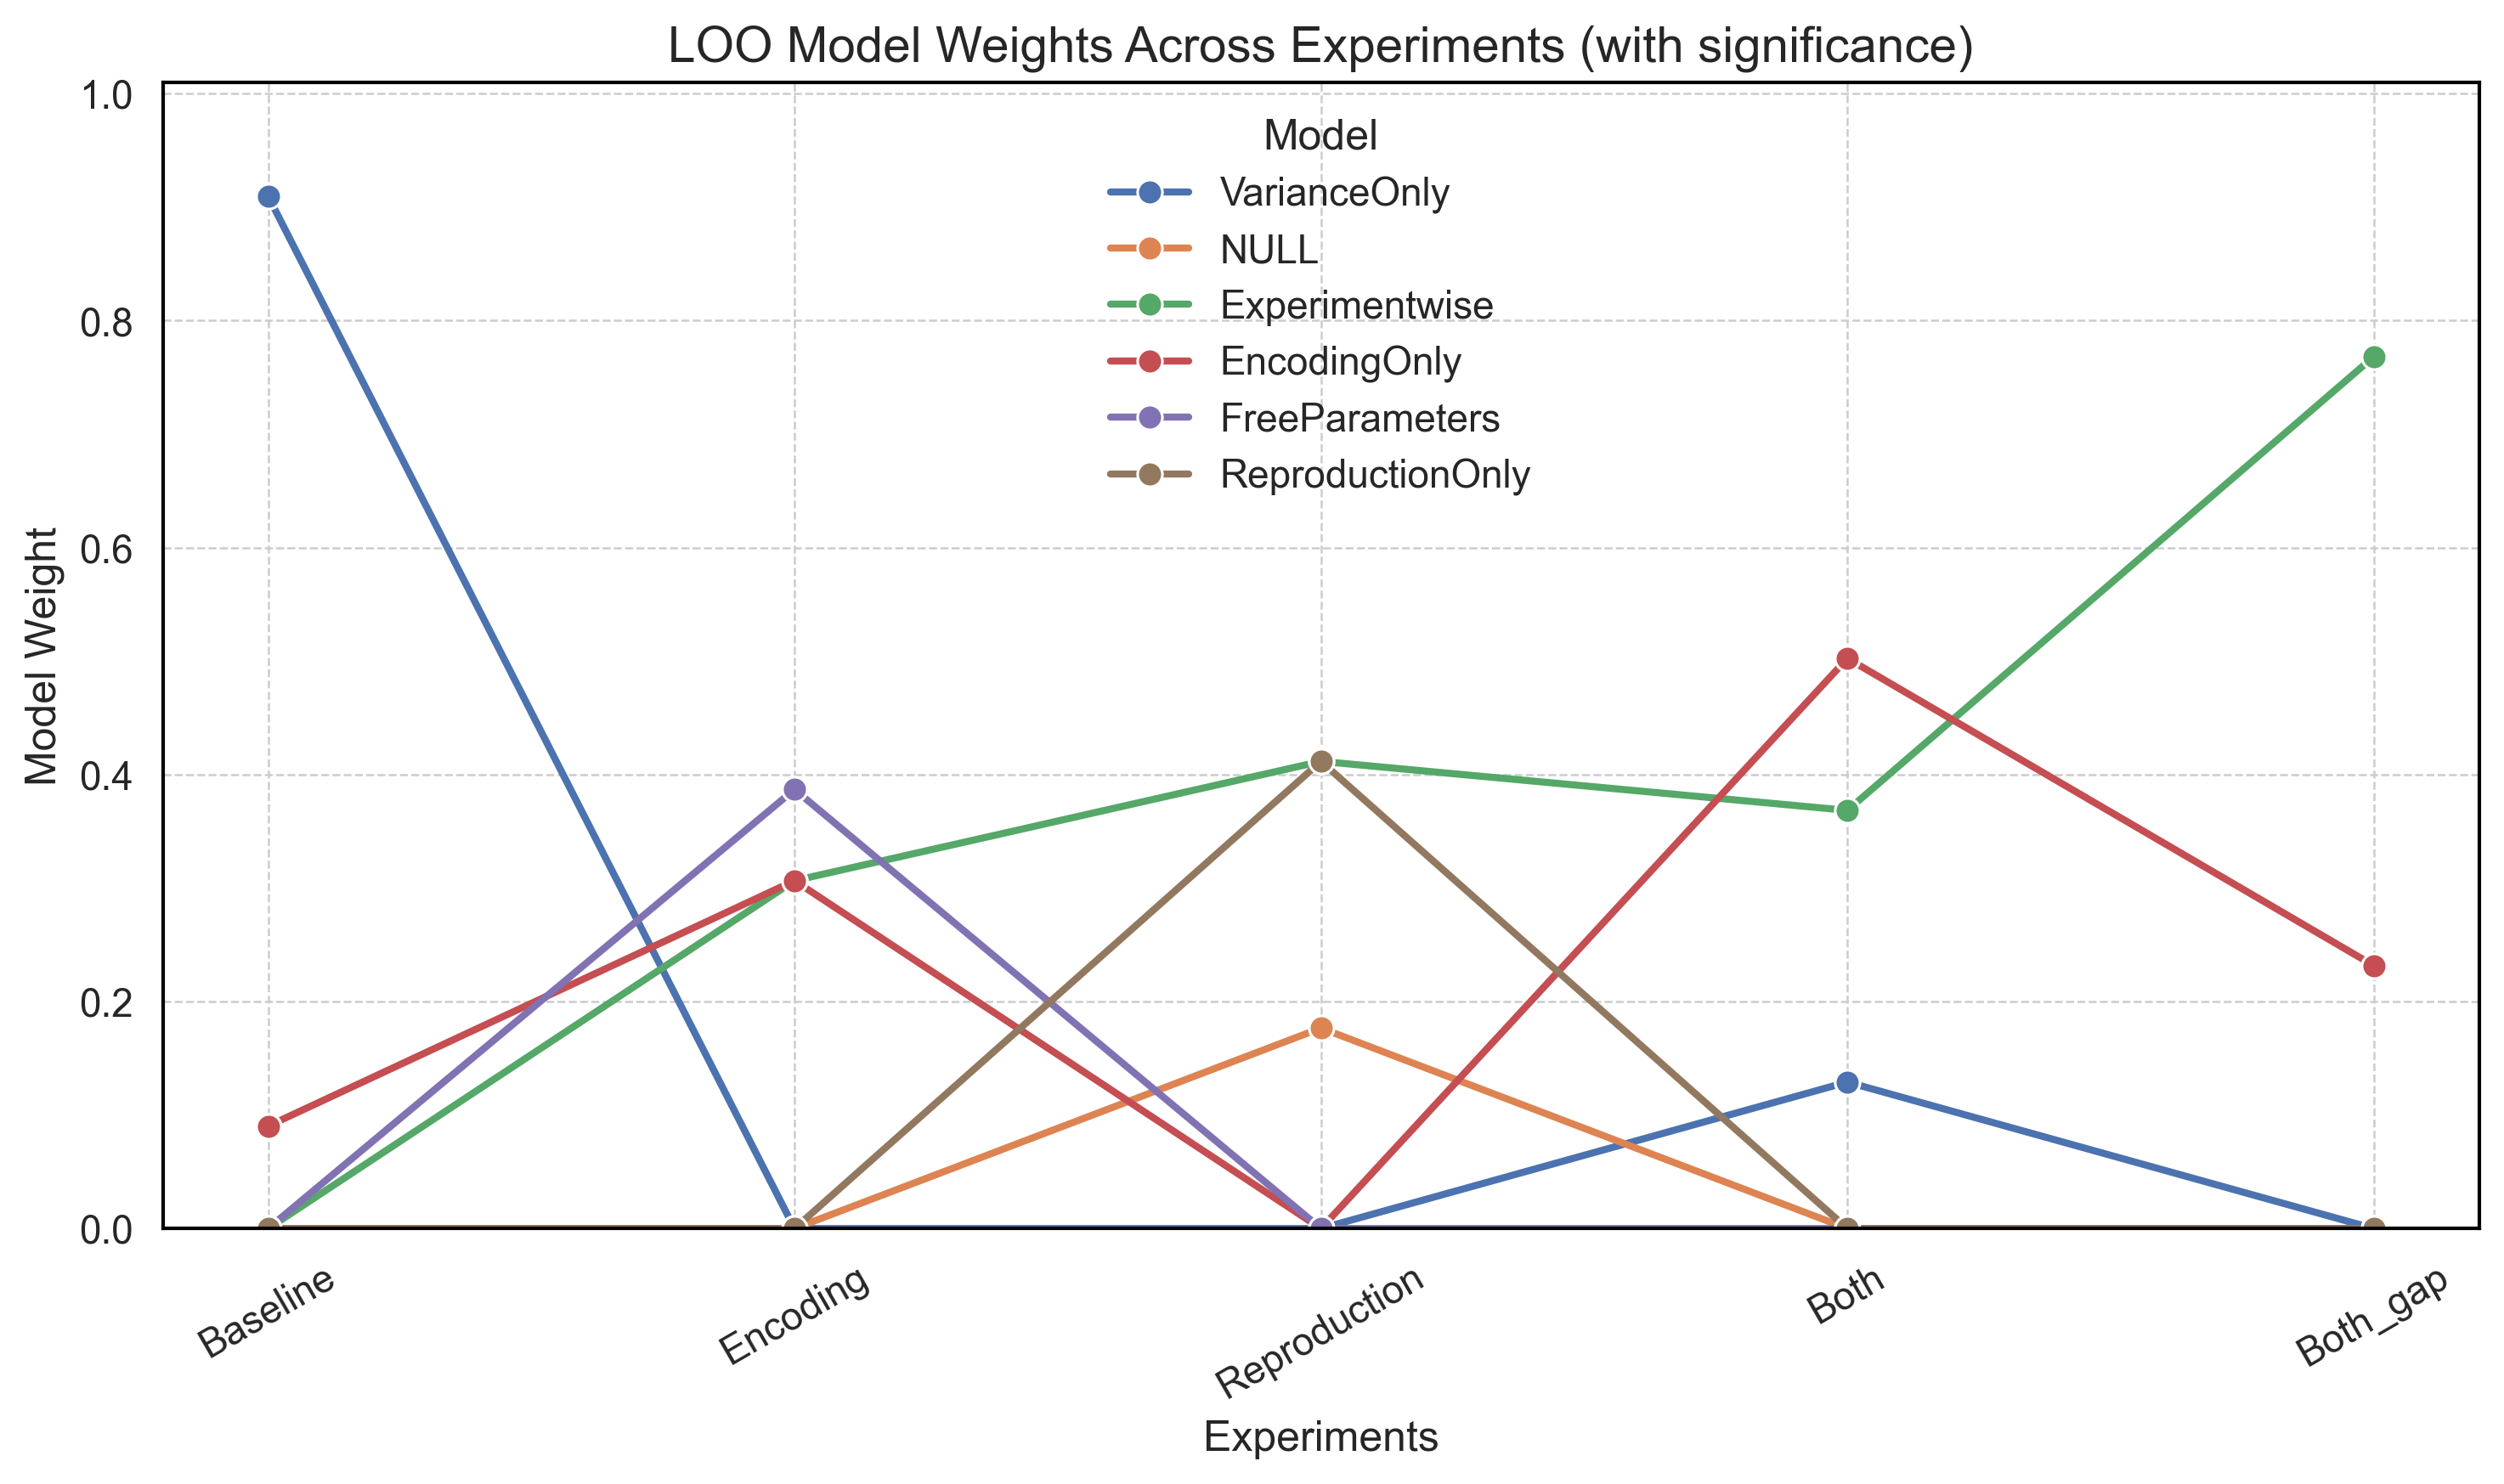

✅ Saved plot: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/loo_model_weights_significance.png


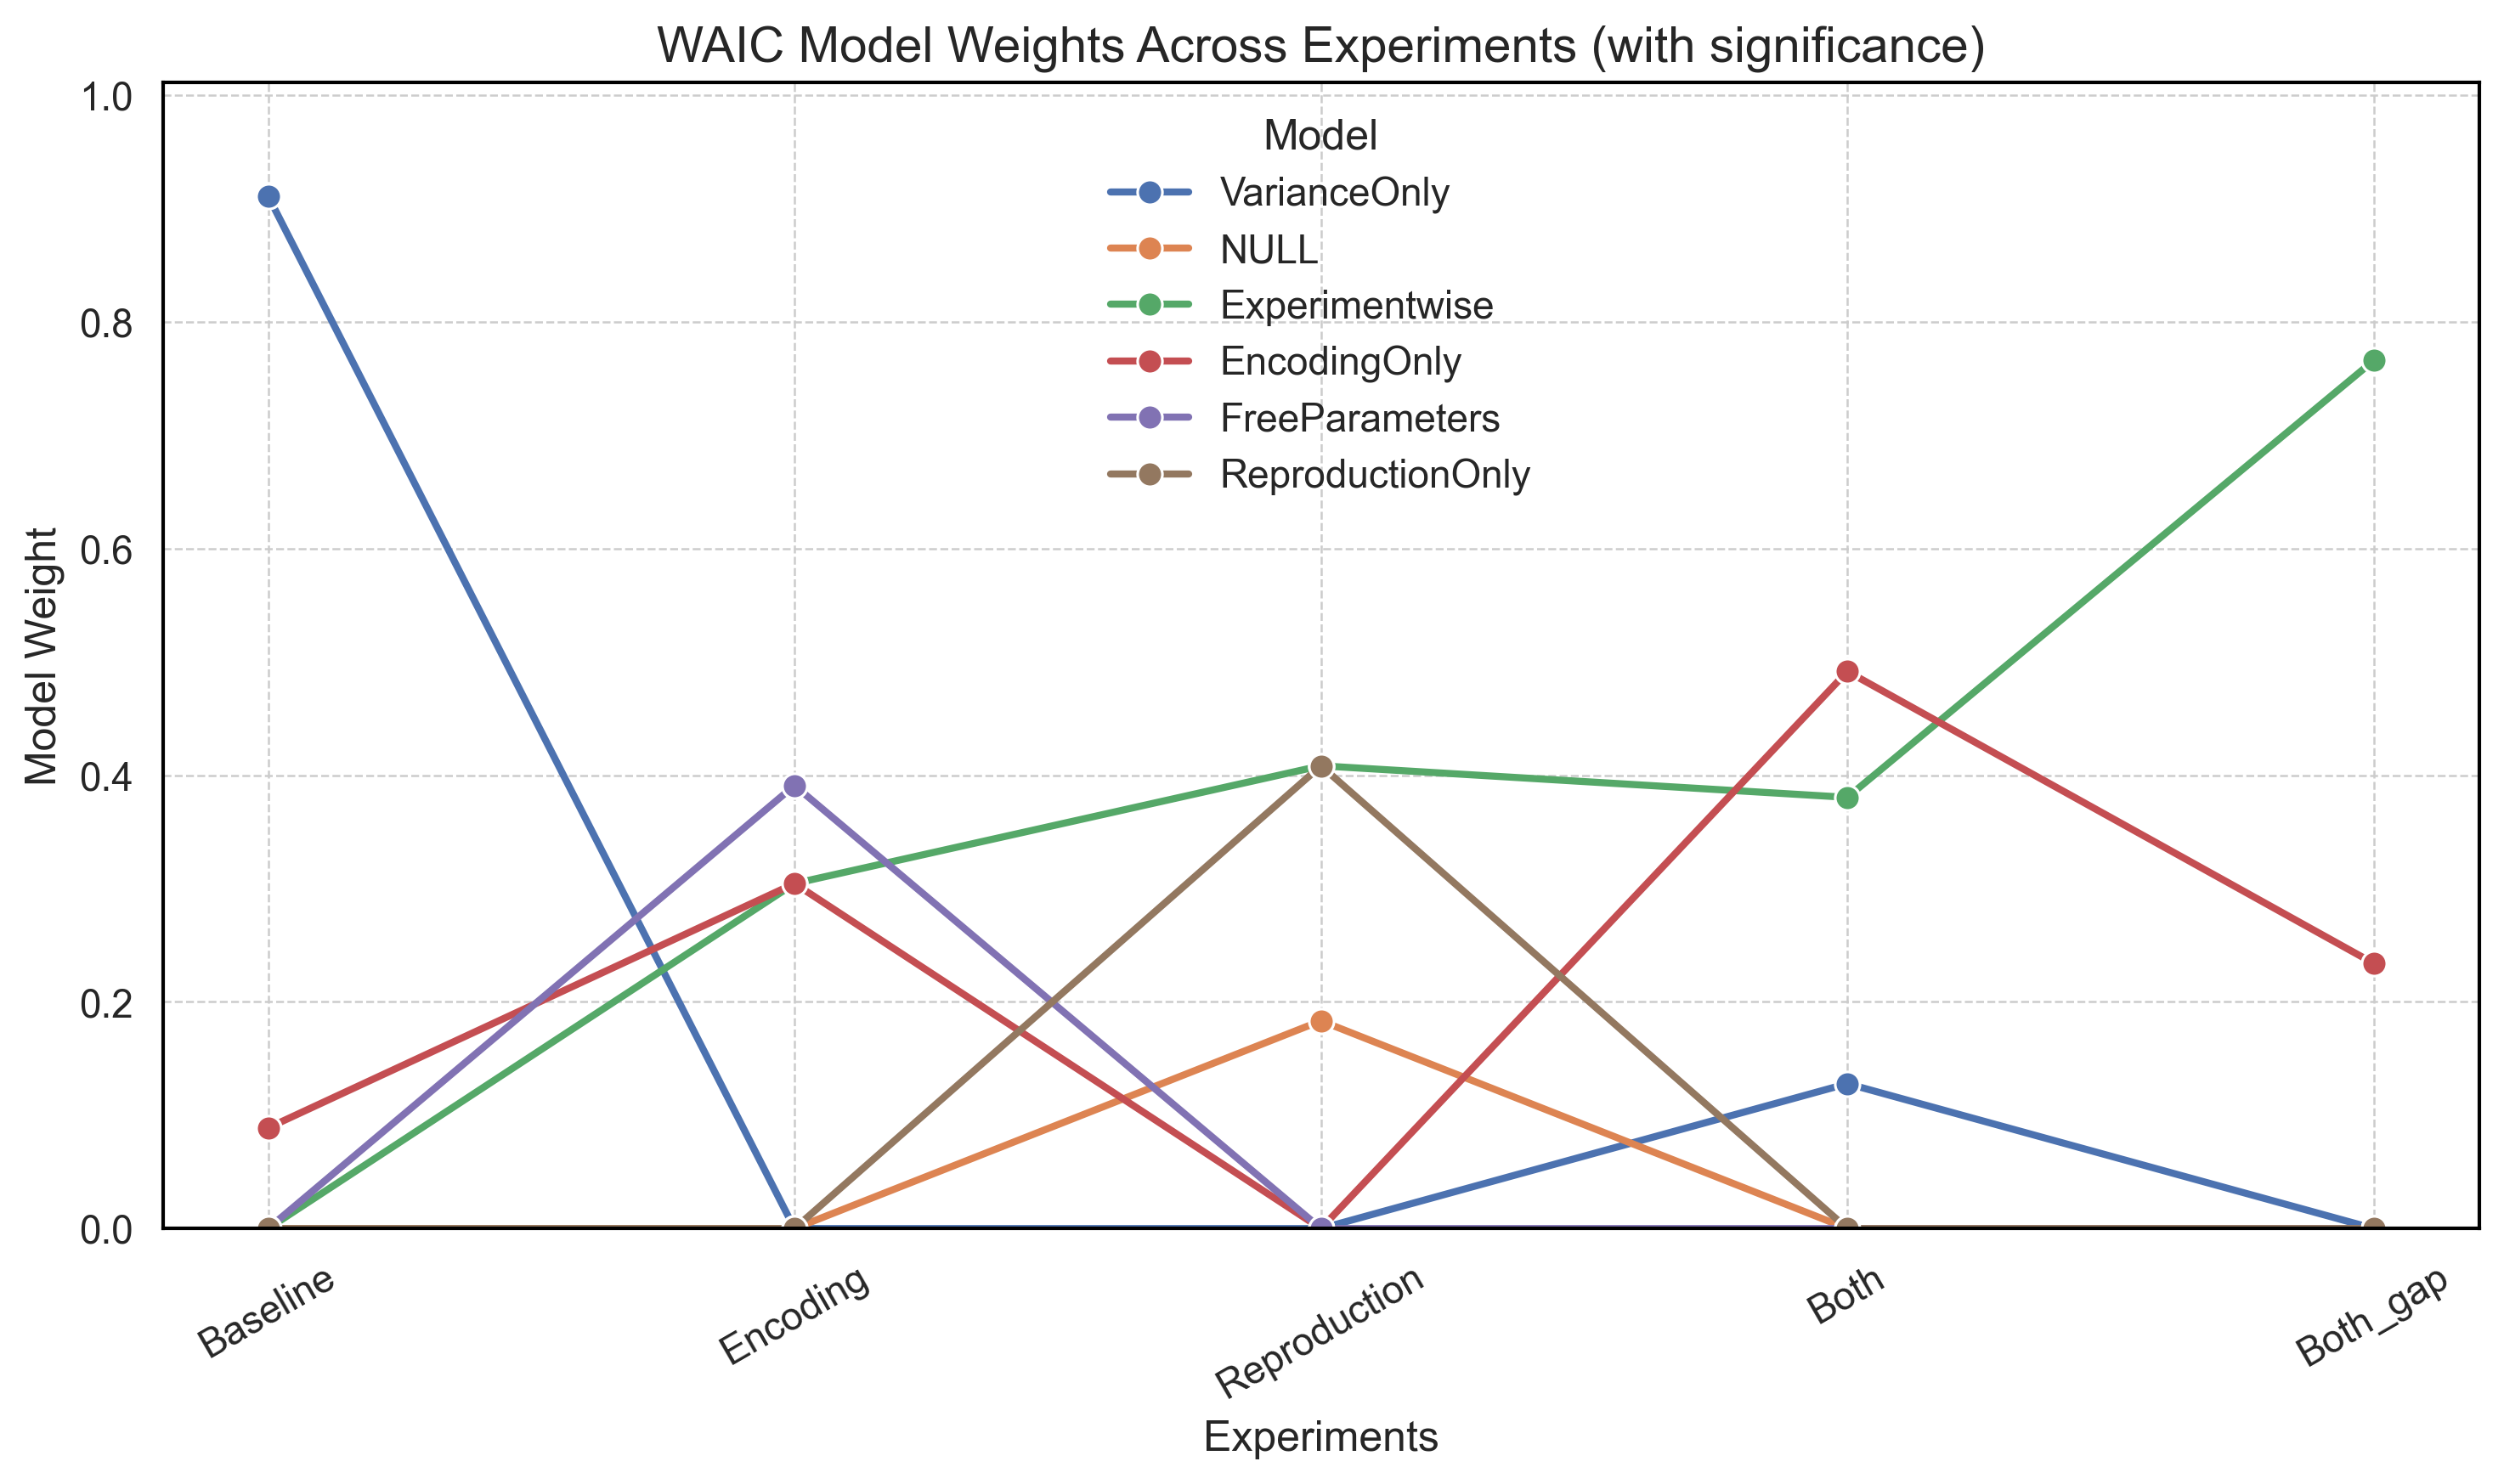

✅ Saved plot: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/waic_model_weights_significance.png


In [388]:
def plot_model_weights(summary, output_path):
    """
    绘制每个实验中模型权重变化，并标记显著性。
    summary: DataFrame, 包含 experiment, ic_type, model_full, weight, significant
    output_path: 保存图片的路径
    """
    sns.set(style="whitegrid", font_scale=1.1)
    sns.set_theme(
    context="paper",
    style="whitegrid",
    font_scale=1.3,
    rc={
        "grid.linestyle": "--",
        "grid.linewidth": 0.6,
        "axes.edgecolor": "black",
        "axes.linewidth": 1.0,
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        "legend.title_fontsize": 12,
        "lines.linewidth": 2,
        "lines.markersize": 7,
        "figure.dpi": 300,
        "savefig.dpi": 300,
    }
)

    for ic in summary['ic_type'].unique():
        df_ic = summary[summary['ic_type'] == ic].copy()
        plt.figure(figsize=(10, 6))

        # 绘制折线图：x=experiment, y=weight, hue=model_full
        sns.lineplot(
            data=df_ic,
            x='experiment',
            y='weight',
            hue='model_full',
            marker='o',
            linewidth=2
        )

        # 标记显著性
        for _, row in df_ic.iterrows():
            if row.get('significant', False):
                plt.text(
                    row['experiment'],
                    row['weight'] + 0.02,  # 稍微上移一点
                    "*",
                    color="red",
                    fontsize=14,
                    ha="center",
                    va="bottom"
                )

        plt.title(f"{ic.upper()} Model Weights Across Experiments (with significance)", fontsize=14)
        plt.ylabel("Model Weight")
        plt.xlabel("Experiments")
        plt.xticks(rotation=30)
        plt.ylim(0, df_ic['weight'].max() + 0.1)
        plt.legend(title="Model", loc='best')
        plt.tight_layout()

        # 保存图片
        filename = os.path.join(output_path, f"{ic}_model_weights_significance.png")
        plt.savefig(filename, dpi=300)
        plt.show()
        print(f"✅ Saved plot: {filename}")

# ---------------------------
# Example usage
# ---------------------------
plot_model_weights(summary_df, OUTPUT_PATH)

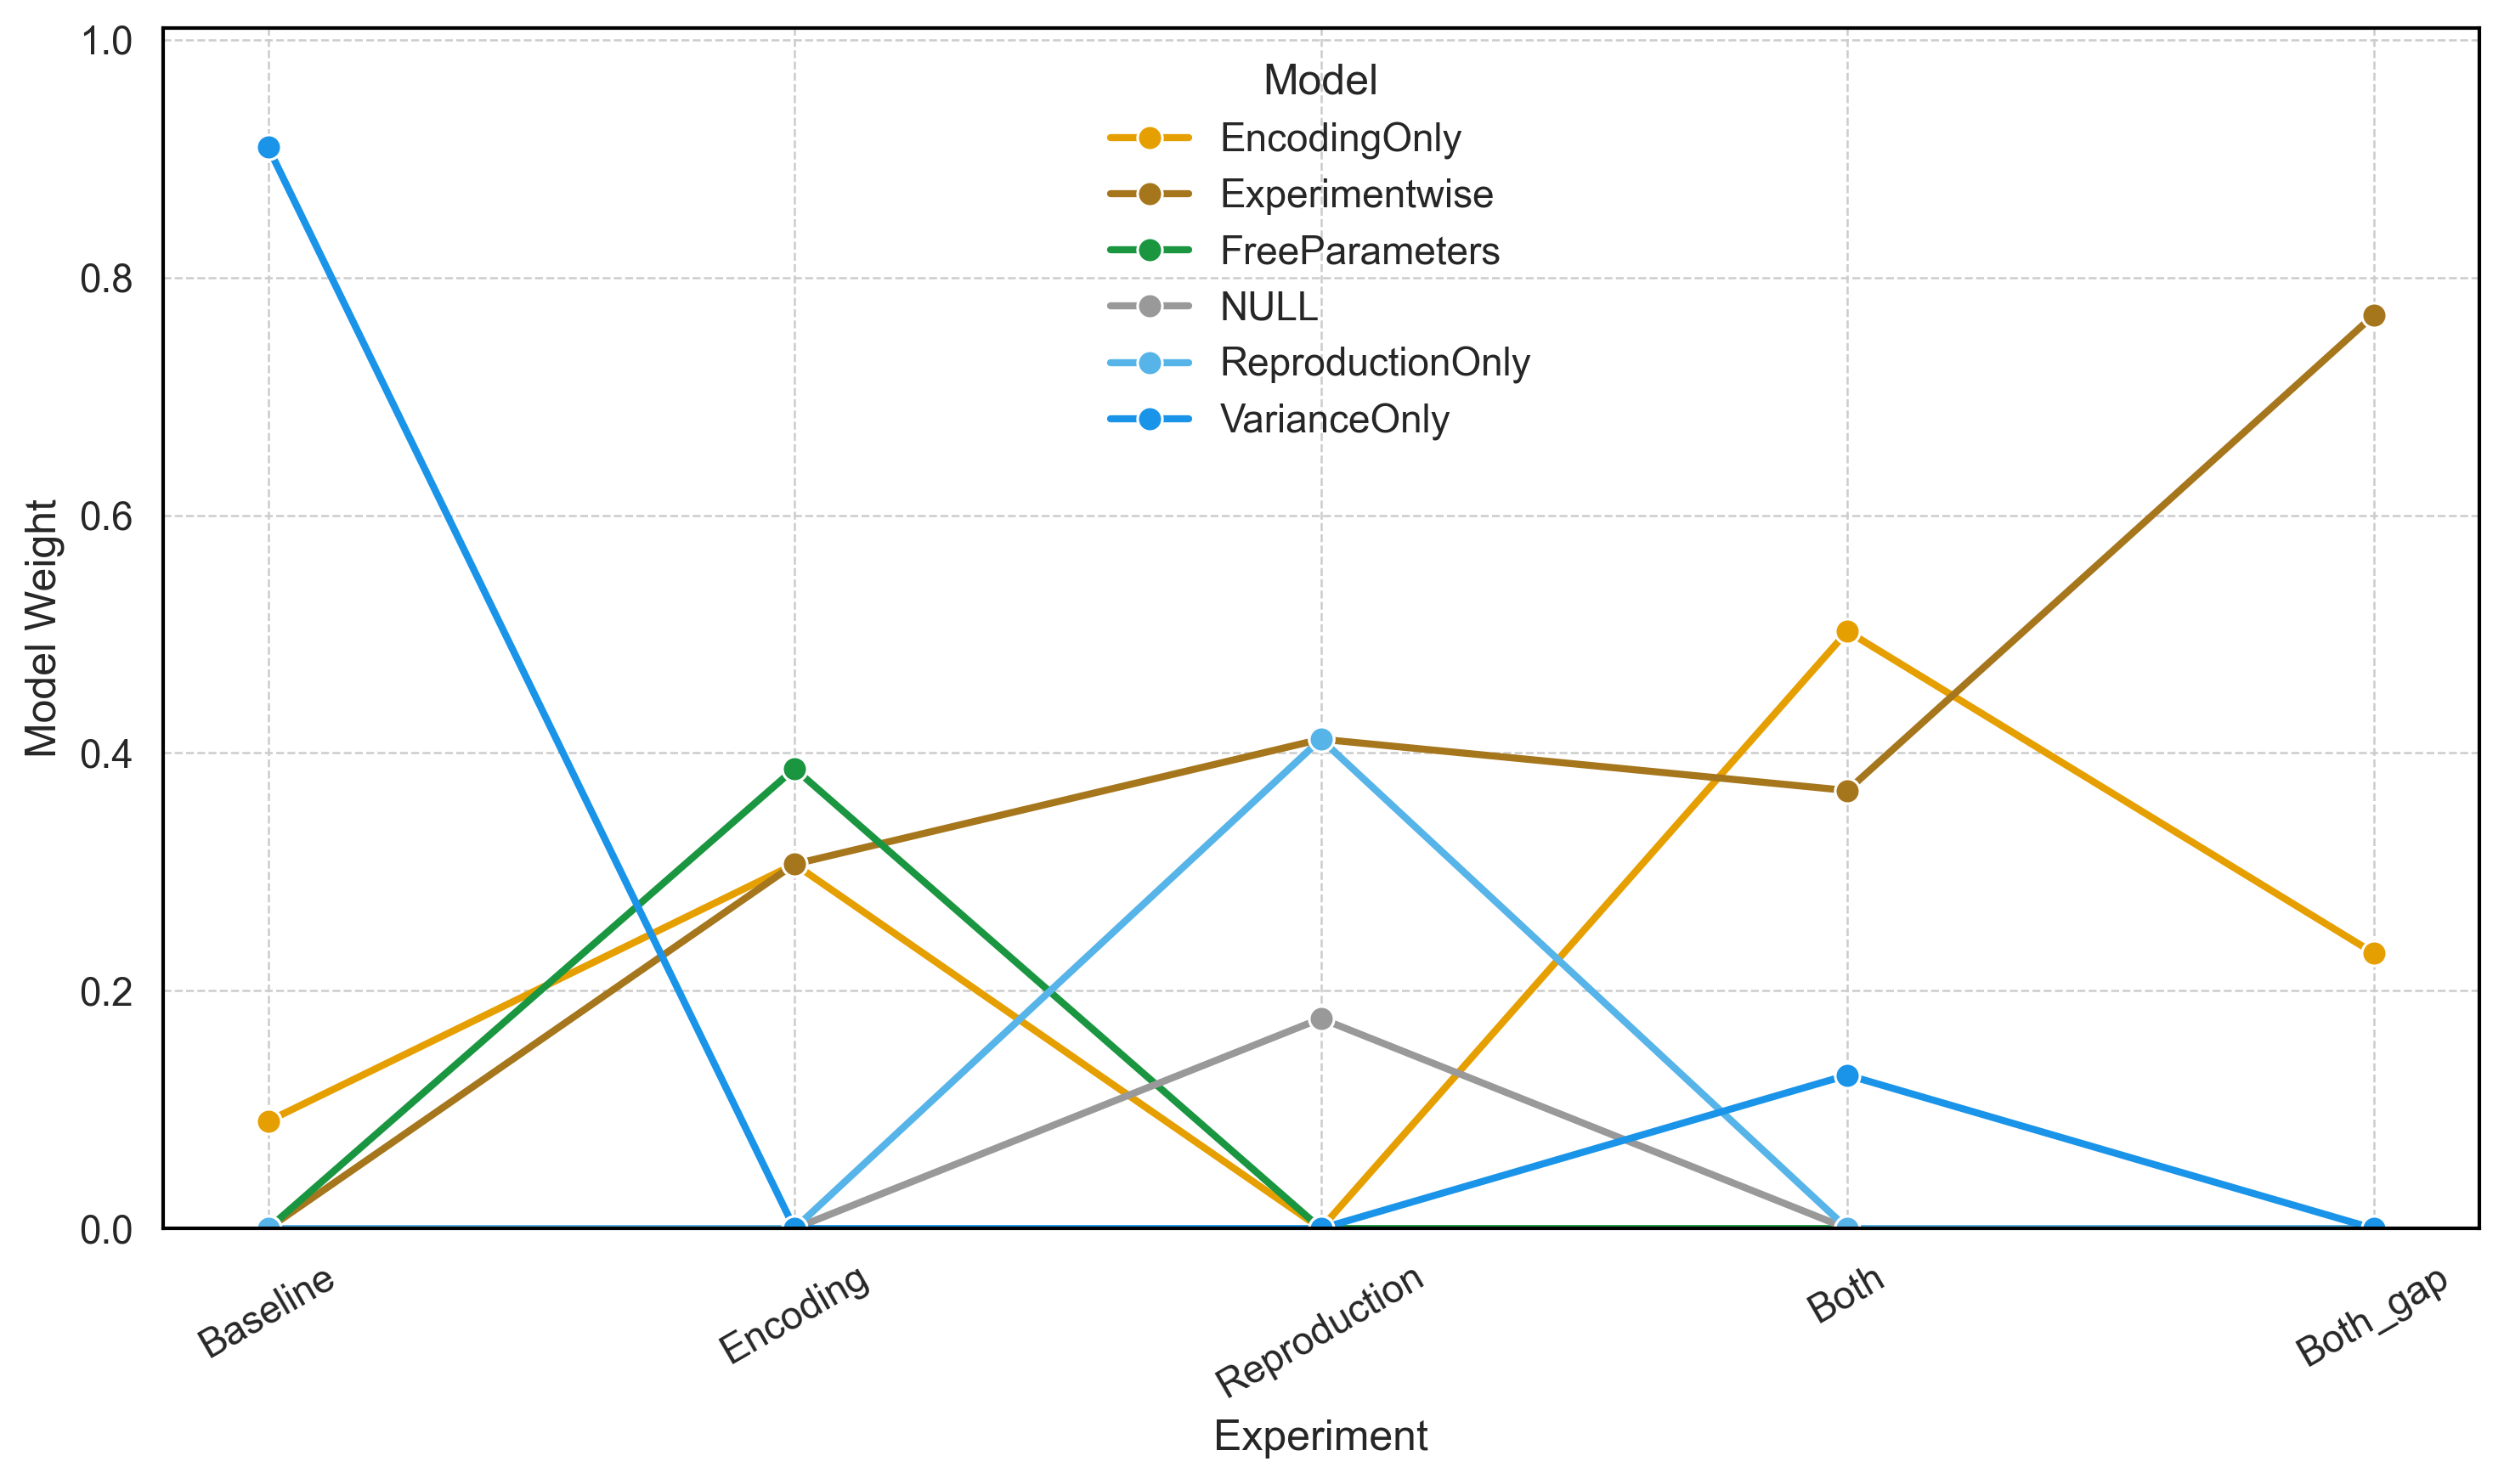

✅ Saved plot: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/loo_model_weights_significance.png


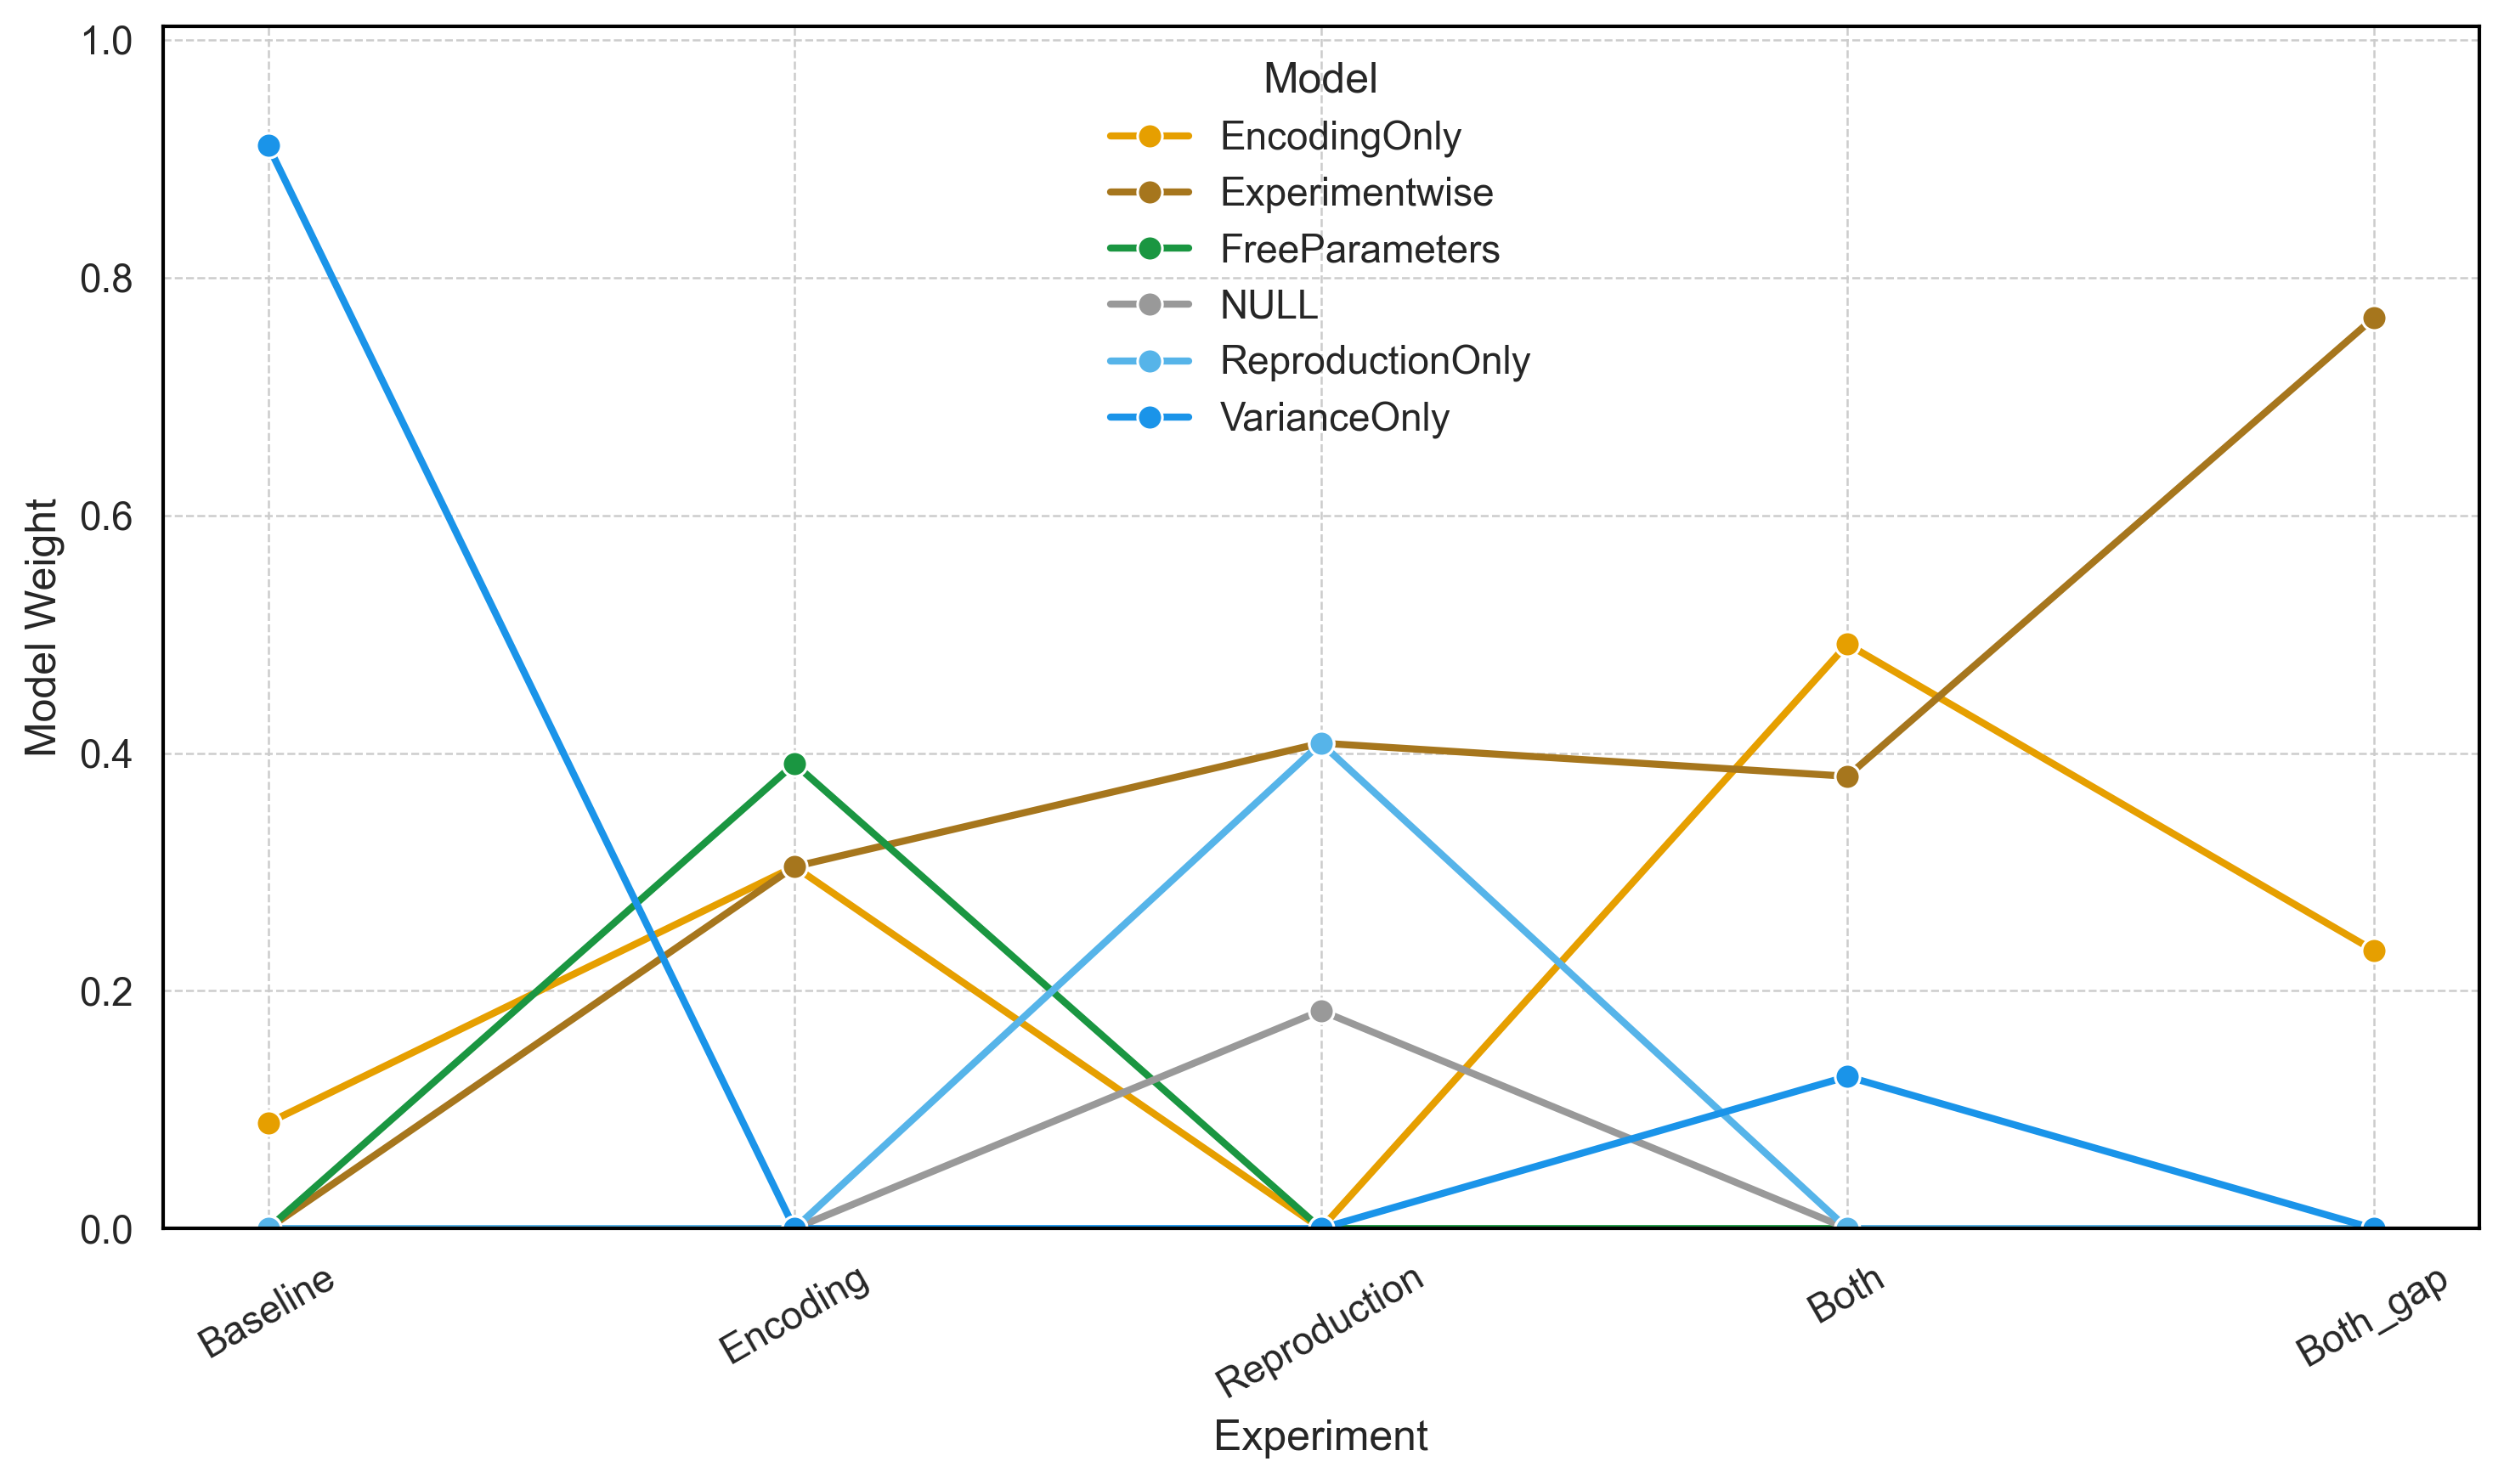

✅ Saved plot: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/waic_model_weights_significance.png


In [411]:
def plot_model_weights(summary, output_path):
    """
    绘制每个实验中模型权重变化，并标记显著性。
    summary: DataFrame, 包含 experiment, ic_type, model_full, weight, significant
    output_path: 保存图片的路径
    """
    sns.set(style="whitegrid", font_scale=1.1)
    # APA-style global settings
    sns.set_theme(
        context="paper",
        style="whitegrid",
        font_scale=1.3,
        rc={
            "grid.linestyle": "--",
            "grid.linewidth": 0.6,
            "axes.edgecolor": "black",
            "axes.linewidth": 1.0,
            "axes.labelsize": 12,
            "axes.titlesize": 13,
            "xtick.labelsize": 11,
            "ytick.labelsize": 11,
            "legend.fontsize": 11,
            "legend.title_fontsize": 12,
            "lines.linewidth": 2,
            "lines.markersize": 7,
            "figure.dpi": 300,
            "savefig.dpi": 300,
        }
    )
    
    # APA-like palette (desaturated, color-blind friendly)
    model_colors = {
        'NULL':              "#999999",   
        'EncodingOnly':      "#E69F00",   
        'ReproductionOnly':   "#56B4E9", 
        'VarianceOnly':  "#1a94E9", 
        'FreeParameters':      "#1a9641", 
        'Experimentwise':      "#A6761D"  
    }

    for ic in summary['ic_type'].unique():
        df_ic = summary[summary['ic_type'] == ic].copy()
        plt.figure(figsize=(10, 6))

        # 绘制折线图：x=experiment, y=weight, hue=model_full
        sns.lineplot(
            data=df_ic,
            x='experiment',
            y='weight',
            hue='model_full',
            hue_order= models,
            palette=model_colors,
            marker='o',
            linewidth=2
        )

        # 标记显著性
        for _, row in df_ic.iterrows():
            if row.get('significant', False):
                plt.text(
                    row['experiment'],
                    row['weight'] + 0.02,  # 稍微上移一点
                    "*",
                    color="red",
                    fontsize=14,
                    ha="center",
                    va="bottom"
                )

        plt.title("", fontsize=14)
        plt.ylabel("Model Weight")
        plt.xlabel("Experiment")
        plt.xticks(rotation=30)
        plt.ylim(0, df_ic['weight'].max() + 0.1)
        plt.legend(title="Model", loc='best')
        plt.tight_layout()

        # 保存图片
        filename = os.path.join(output_path, f"{ic}_model_weights_significance.png")
        plt.savefig(filename, dpi=300)
        plt.show()
        print(f"✅ Saved plot: {filename}")

# ---------------------------
# Example usage
# ---------------------------
plot_model_weights(summary_df, OUTPUT_PATH)

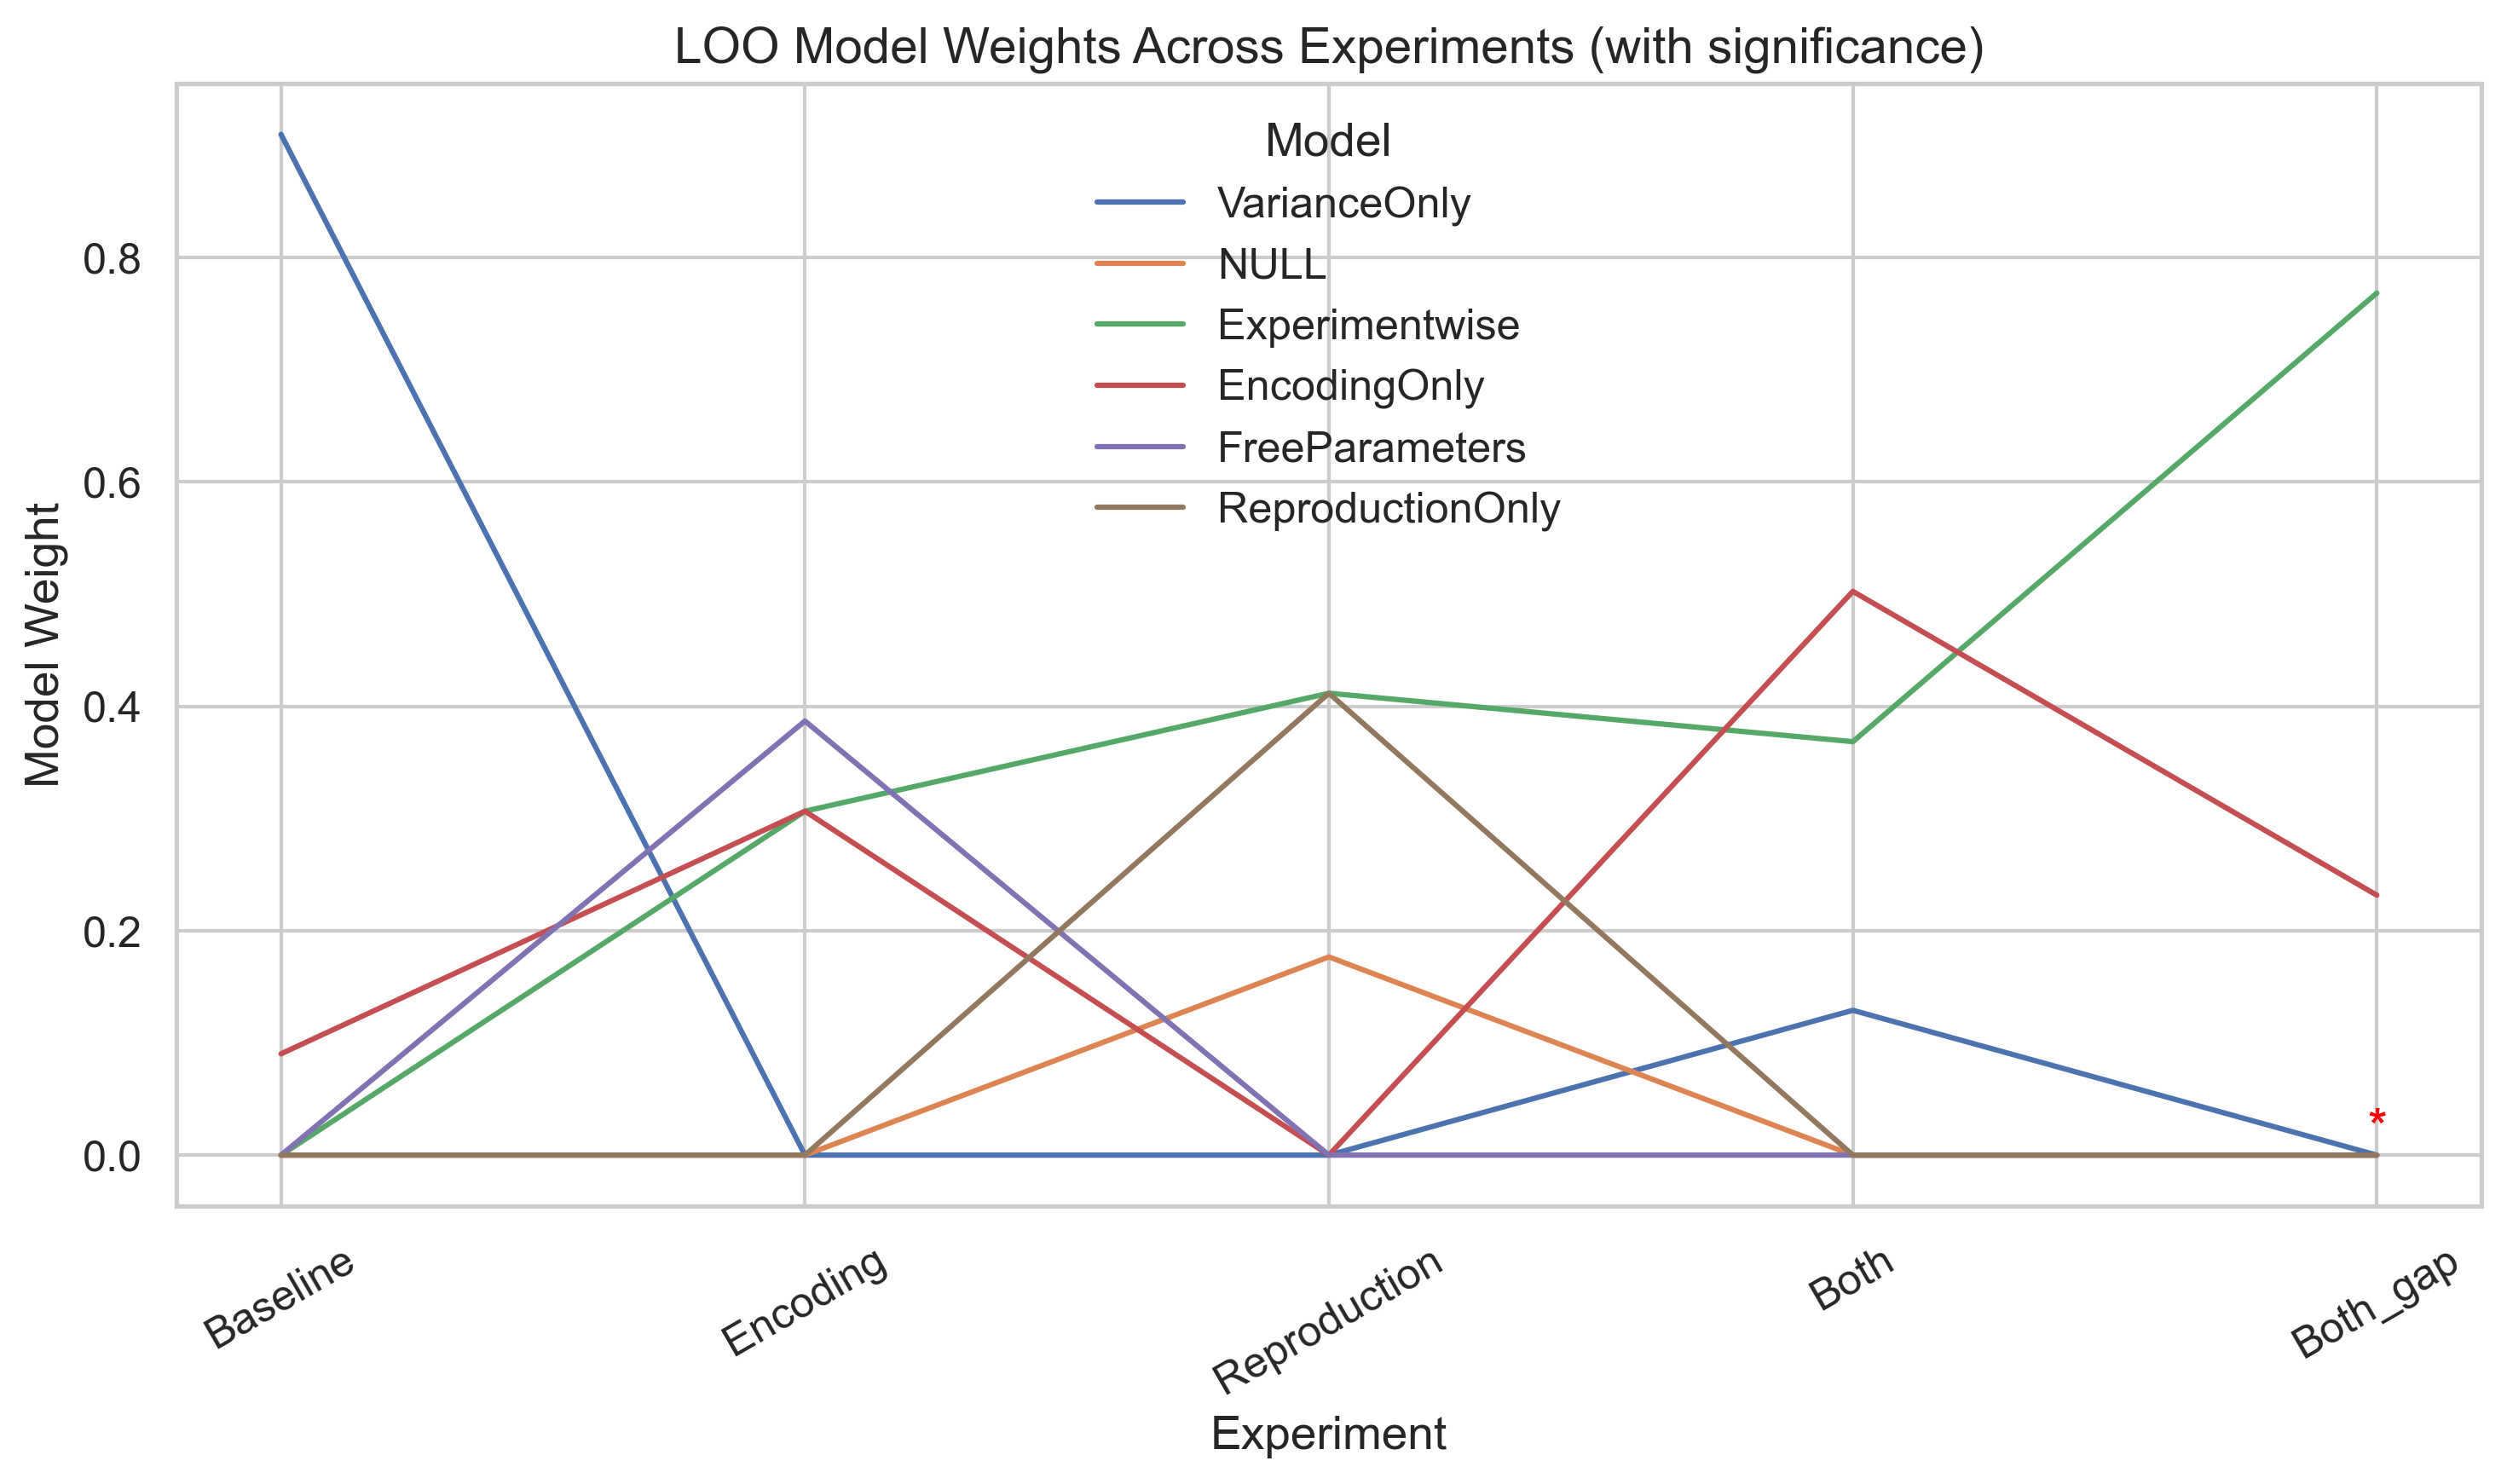

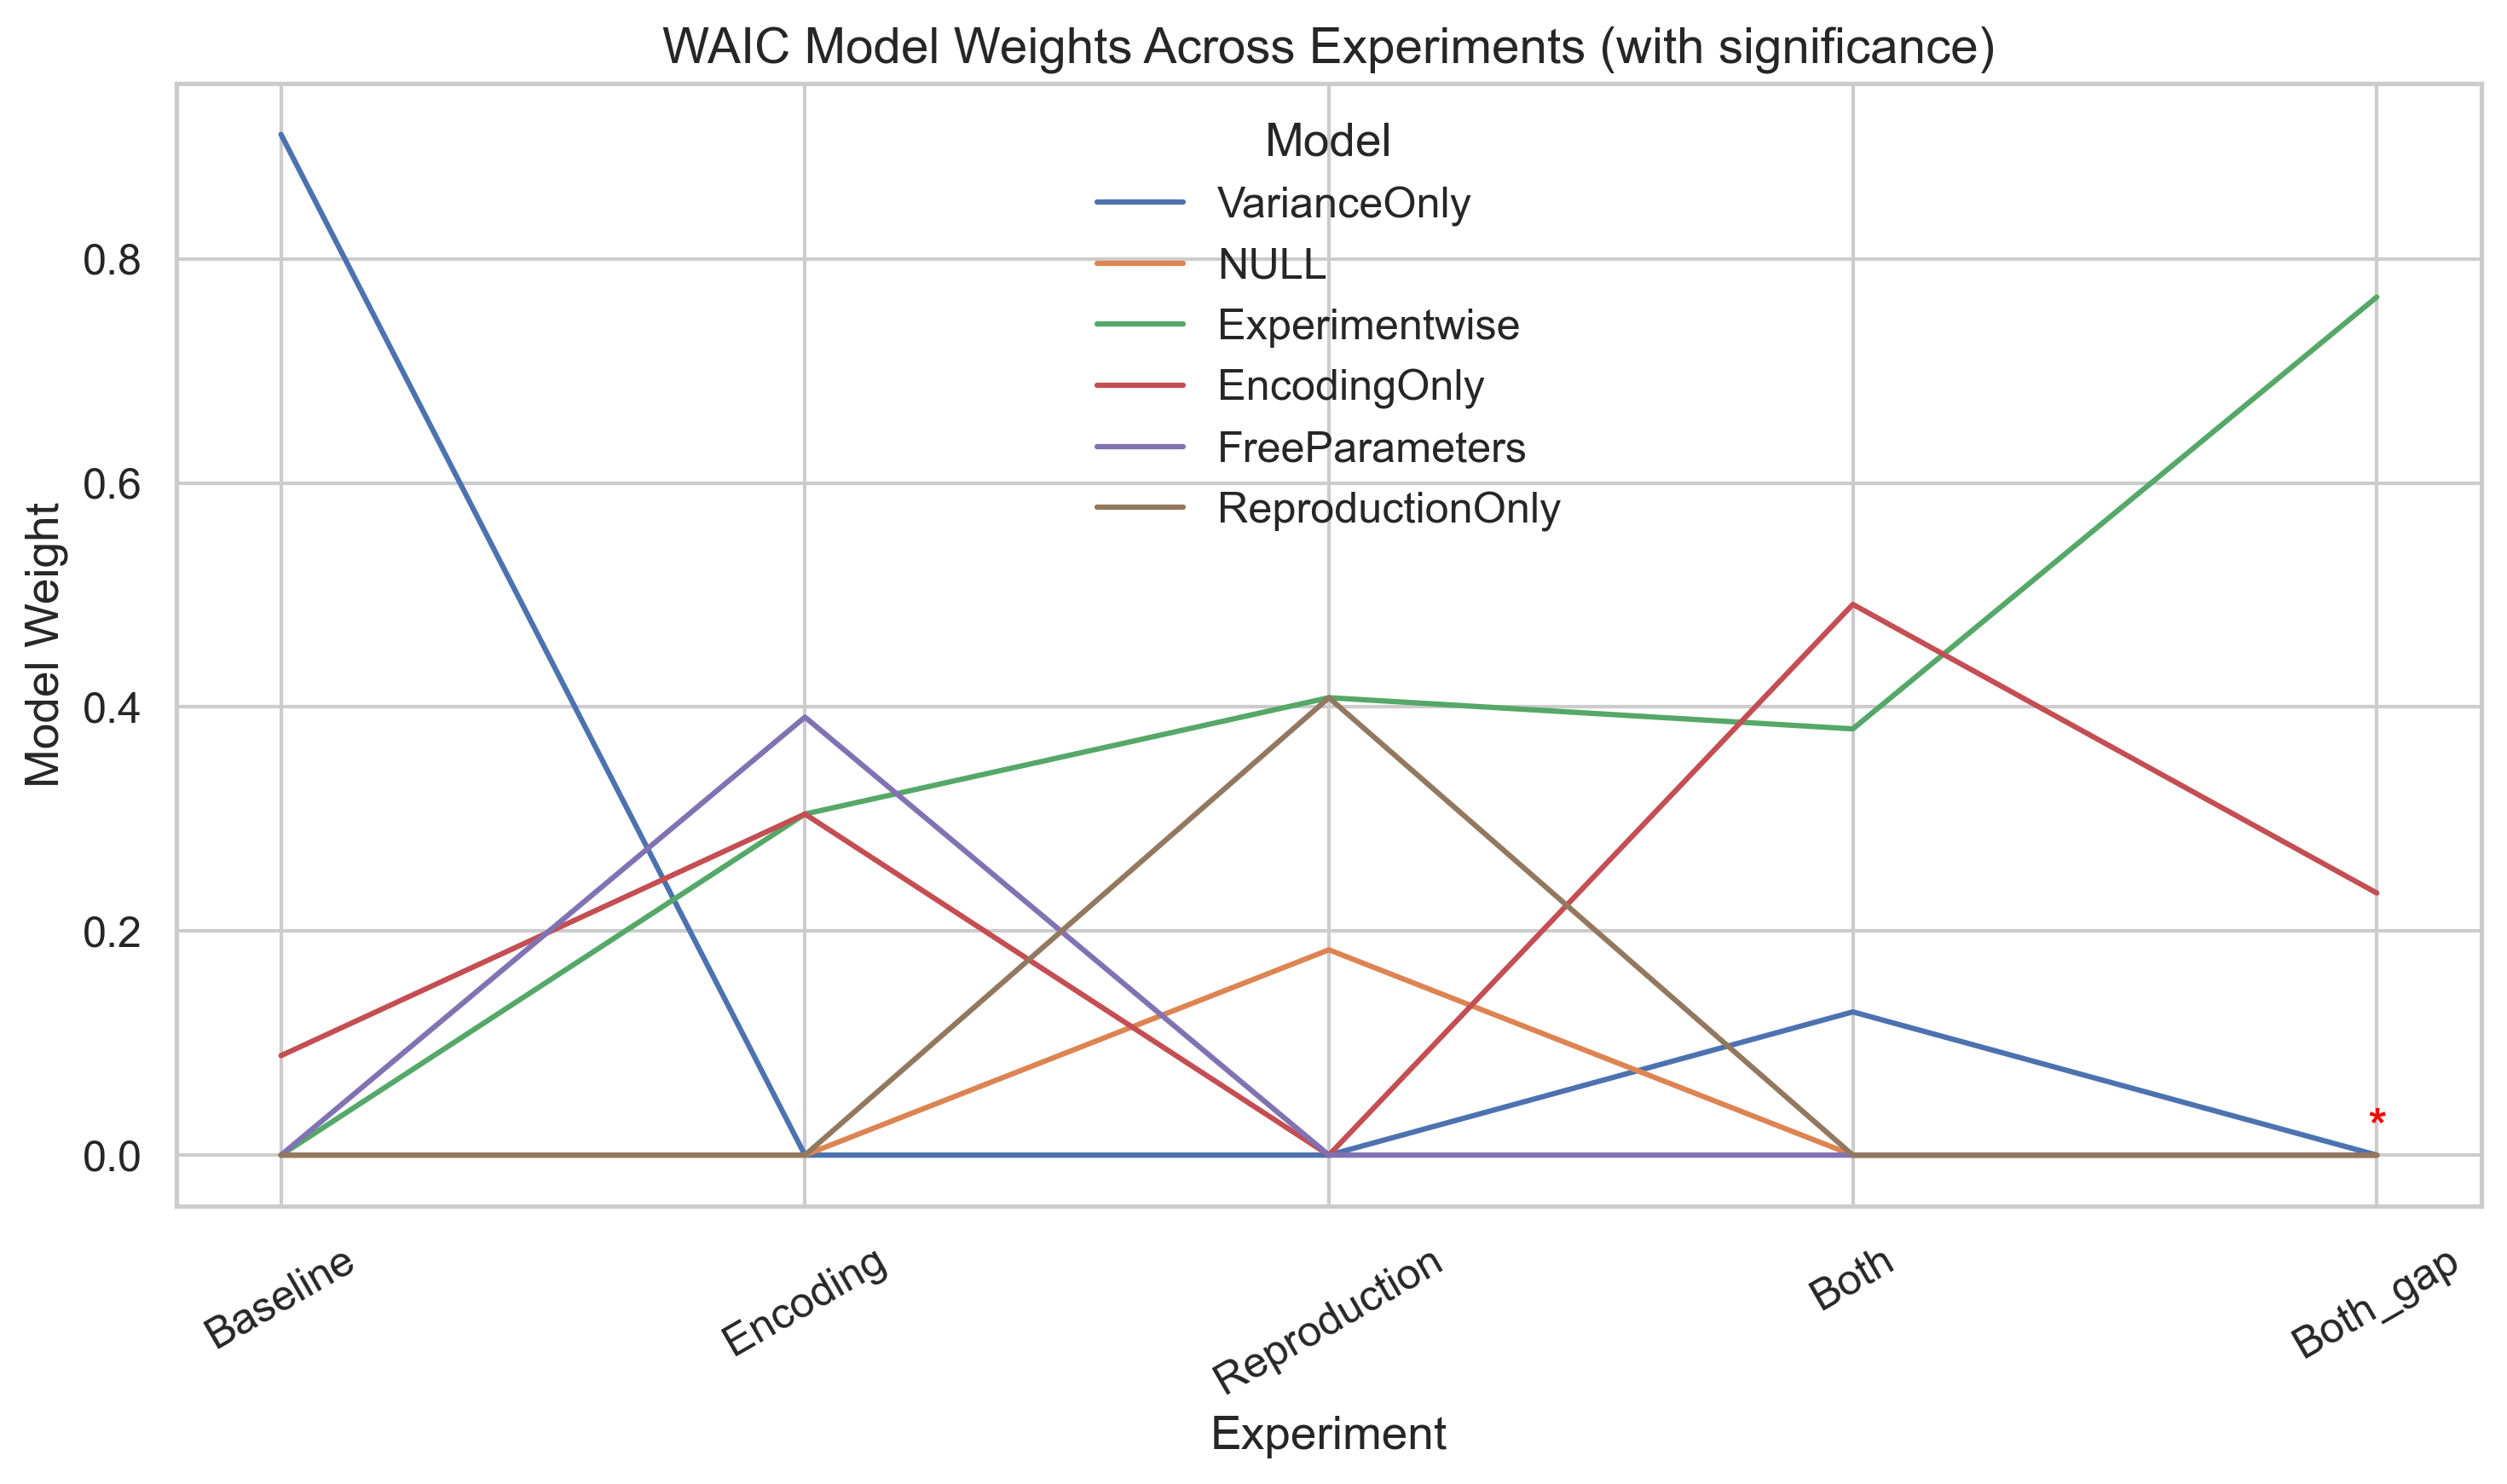


=== Average model weights summary ===
   ic_type        model_full  mean_weight  mean_elpd_diff     mean_se  \
0      loo      EncodingOnly     0.226190       23.619991  172.498489   
1      loo    Experimentwise     0.371004        1.055129  172.587386   
2      loo    FreeParameters     0.077381        5.554200  172.730338   
3      loo              NULL     0.035333      154.829942  172.675167   
4      loo  ReproductionOnly     0.082333      156.747622  172.615577   
5      loo      VarianceOnly     0.207758      149.012696  172.770706   
6     waic      EncodingOnly     0.223783       23.497603  172.414888   
7     waic    Experimentwise     0.371875        0.978697  172.501086   
8     waic    FreeParameters     0.078204        5.272809  172.619899   
9     waic              NULL     0.036658      154.530209  172.536786   
10    waic  ReproductionOnly     0.081671      156.656738  172.537255   
11    waic      VarianceOnly     0.207809      148.388749  172.587023   

    signifi

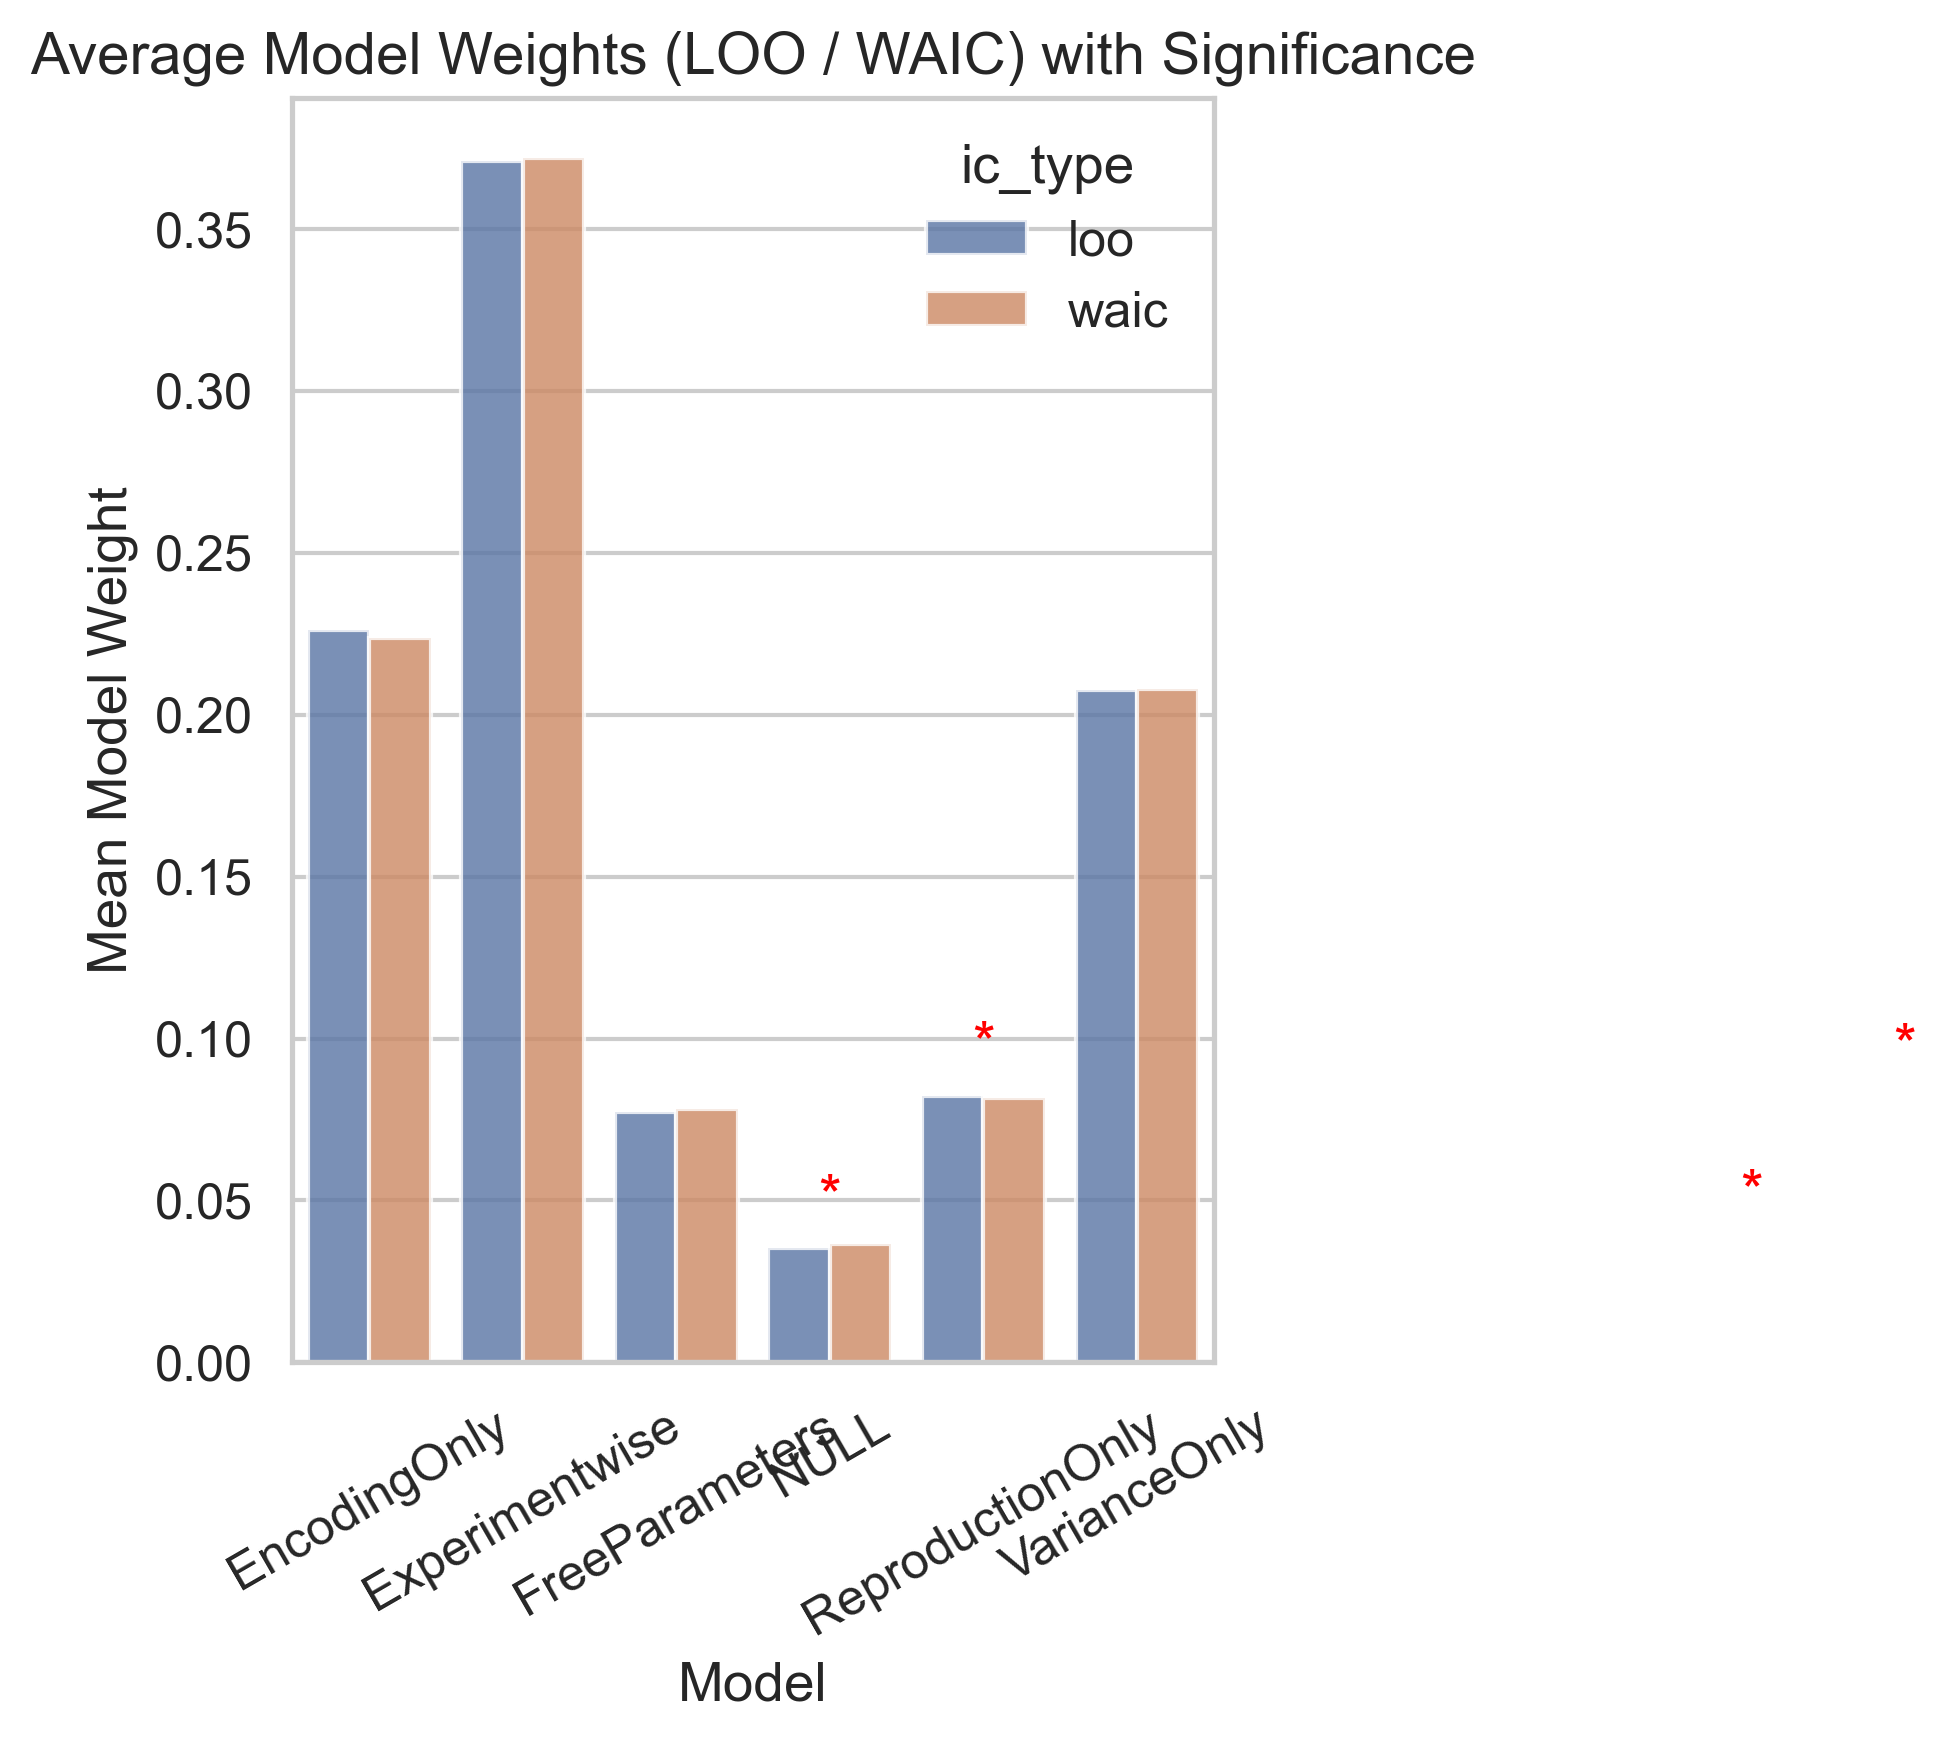

In [413]:
# ===================================================================
# 1. 添加统计显著性标记
# ===================================================================
summary['significant'] = False
mask = summary['ic_type'].isin(['loo', 'waic']) & summary['elpd_diff'].notna() & summary['se'].notna()
summary.loc[mask, 'significant'] = summary.loc[mask, 'elpd_diff'].abs() > 2 * summary.loc[mask, 'se']


# ===================================================================
# 2. 逐 IC 绘制 model weight + 显著性
# ===================================================================
sns.set(style="whitegrid", font_scale=1.1)

for ic in summary['ic_type'].unique():
    df = summary[summary['ic_type'] == ic]

    # 跳过没有 weight 的指标（比如 PPC）
    if 'weight' not in df.columns or df['weight'].isna().all():
        continue

    plt.figure(figsize=(10, 6))

    sns.lineplot(
        data=df,
        x='experiment',
        y='weight',
        hue='model_full',        # 不再拆分 model / setting
        markers=True
    )

    # 添加显著性标记
    for _, row in df.iterrows():
        if row['significant']:
            plt.text(
                row['experiment'],
                row['weight'] + 0.01,
                "*",
                color="red",
                fontsize=14,
                ha="center",
            )

    plt.title(f'{ic.upper()} Model Weights Across Experiments (with significance)', fontsize=14)
    plt.ylabel('Model Weight')
    plt.xlabel('Experiment')
    plt.xticks(rotation=30)
    plt.legend(title='Model', loc='best')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f"{ic}_model_weights_significance.png"), dpi=300)
    plt.show()


# ===================================================================
# 3. 平均权重统计（不拆 model）
# ===================================================================
avg = (
    summary[summary['ic_type'].isin(['loo', 'waic'])]
    .groupby(['ic_type', 'model_full'], as_index=False)
    .agg(
        mean_weight=('weight', 'mean'),
        mean_elpd_diff=('elpd_diff', 'mean'),
        mean_se=('se', 'mean'),
        significant_any=('significant', 'any')
    )
)

print("\n=== Average model weights summary ===")
print(avg)


# ===================================================================
# 4. 平均权重柱状图
# ===================================================================
plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg,
    x='model_full',
    y='mean_weight',
    hue='ic_type',      # LOO / WAIC 对比
    alpha=0.8
)

# 添加显著性标记
for i, row in avg.iterrows():
    if row['significant_any']:
        plt.text(
            i,
            row['mean_weight'] + 0.01,
            "*",
            color="red",
            fontsize=14,
            ha="center"
        )

plt.title("Average Model Weights (LOO / WAIC) with Significance", fontsize=14)
plt.ylabel("Mean Model Weight")
plt.xlabel("Model")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, "average_model_weights_significance.png"), dpi=300)
plt.show()

In [414]:
def plot_model_weights_combined(summary, output_path):
    """
    在同一个 figure 中生成 LOO 与 WAIC 的并列子图（1×2），
    显示模型权重并标记显著性。
    """

    sns.set(style="whitegrid", font_scale=1.1)

    # APA-style settings
    sns.set_theme(
        context="paper",
        style="white",      # ← 纯白背景，无网格
        font_scale=1.3,
        rc={
            "axes.edgecolor": "black",
            "axes.linewidth": 1.0,
            "axes.labelsize": 12,
            "axes.titlesize": 13,
            "xtick.labelsize": 11,
            "ytick.labelsize": 11,
            "legend.fontsize": 13,        # ← 更大 legend 字体
            "legend.title_fontsize": 14,  # ← 更大 legend 标题字体
            "lines.linewidth": 2,
            "lines.markersize": 7,
            "figure.dpi": 300,
            "savefig.dpi": 300,
        }
    )

    # APA-like palette
    model_colors = {
        'NULL':              "#4D4D4D",   # dark gray
        'EncodingOnly':      "#7F7F7F",   # medium gray
        'ReproductionOnly':  "#1B9E77",   # green
        'MeanOnly':          "#7570B3",   # indigo
        'VarianceOnly':      "#D95F02",   # orange
        'FreeParameters':    "#E6AB02",   # amber
        'Experimentwise':    "#A6761D"    # brown
    }

    # -------------------------------------------------------------
    # Create figure with 1 row × 2 columns
    # -------------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(9, 6), sharey=True)
    ic_list = ["loo", "waic"]

    for ax, ic in zip(axes, ic_list):

        df_ic = summary[summary['ic_type'] == ic].copy()

        sns.lineplot(
            data=df_ic,
            x='experiment',
            y='weight',
            hue='model_full',
            hue_order=models,
            palette=model_colors,
            marker='o',
            linewidth=2,
            ax=ax
        )

        # Add significance stars
        for _, row in df_ic.iterrows():
            if row.get('significant', False):
                ax.text(
                    row['experiment'],
                    row['weight'] + 0.02,
                    "*",
                    color="red",
                    fontsize=14,
                    ha="center",
                    va="bottom"
                )

        ax.set_title( " Model Weights based on "+ic.upper() , fontsize=14)
        ax.set_xlabel("Experiment")
        ax.set_xticklabels(df_ic['experiment'].unique(), rotation=30)
        ax.set_ylim(0, df_ic['weight'].max() + 0.1)

        if ic == "loo":
            ax.set_ylabel("")
        else:
            ax.set_ylabel("")

    # Unified legend outside subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="", loc="upper center", ncol=3)
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()

    plt.tight_layout(rect=[0, 0, 1, 0.92])

    filename = os.path.join(output_path, "LOO_WAIC_model_weights_combined.png")
    plt.savefig(filename, dpi=300)
    plt.show()

    print(f"✅ Saved combined plot: {filename}")


<ipython-input-391-67530e72b764>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_ic['experiment'].unique(), rotation=30)
<ipython-input-391-67530e72b764>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_ic['experiment'].unique(), rotation=30)


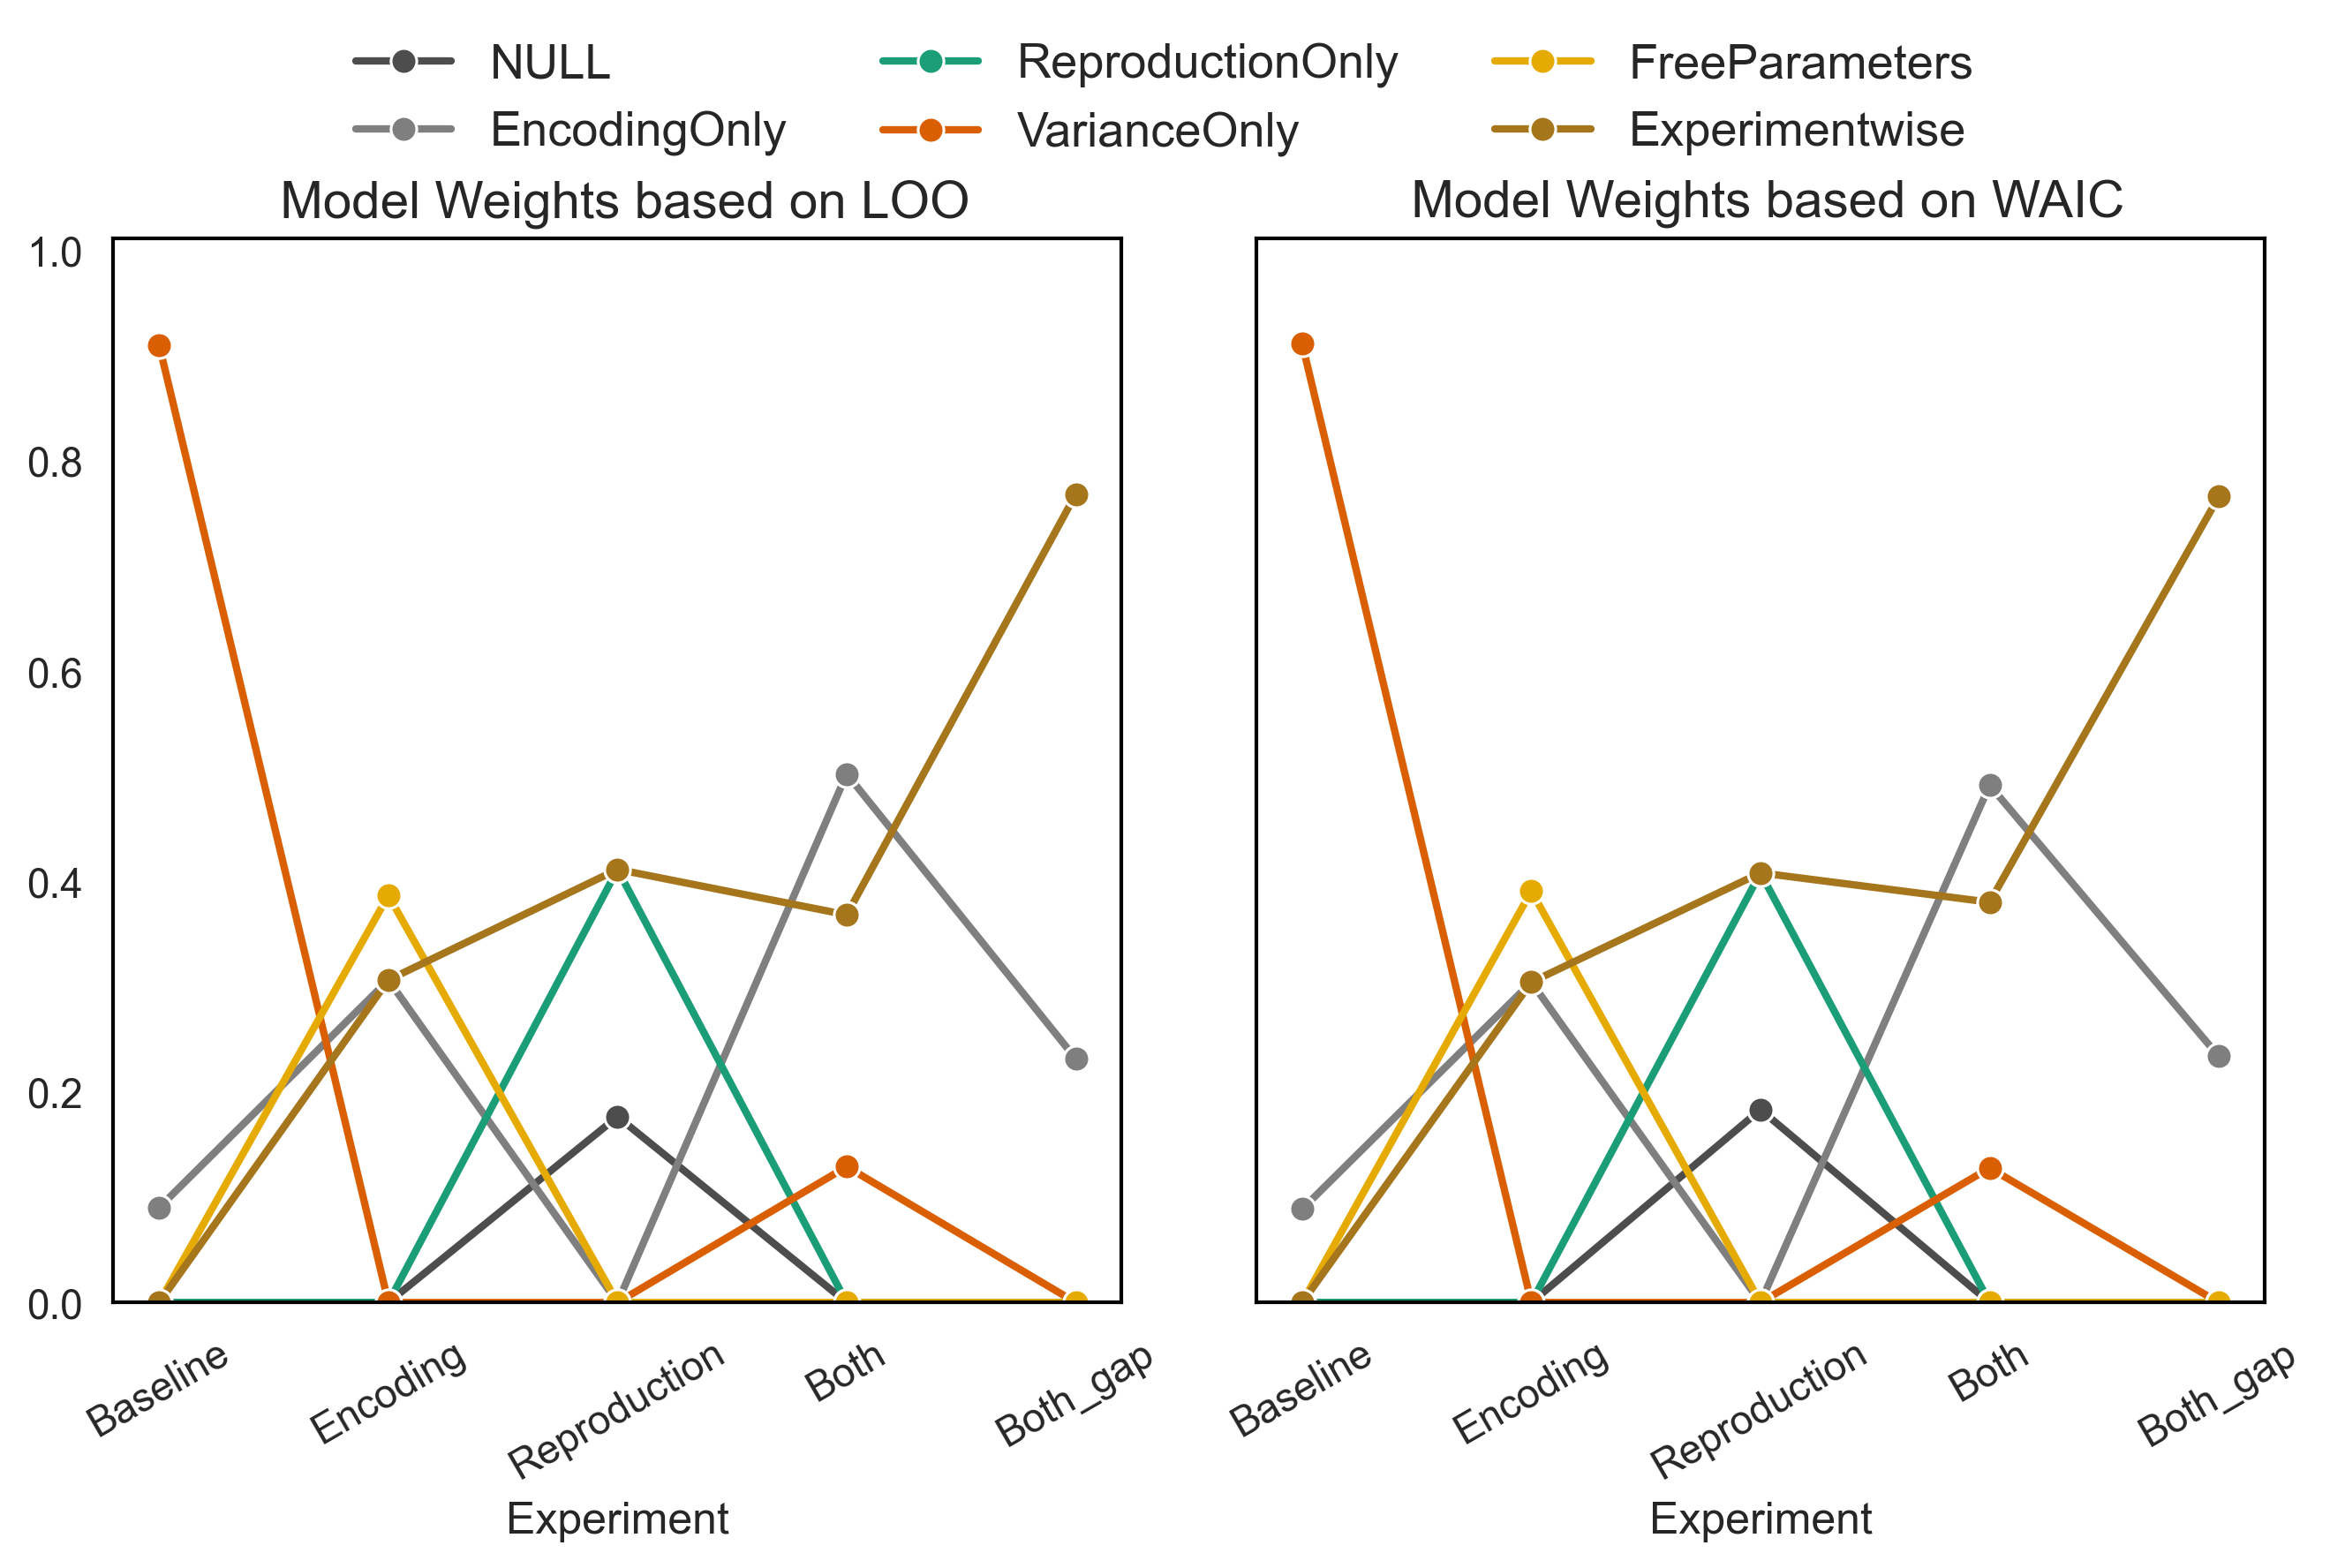

✅ Saved combined plot: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/LOO_WAIC_model_weights_combined.png


In [392]:
plot_model_weights_combined(summary_df, OUTPUT_PATH)


In [415]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_weights_combined2(summary, output_path):
    """
    Robust plotting of model weights for LOO and WAIC.
    - summary: pandas.DataFrame with columns at least:
        ['ic_type', 'experiment', 'model_full', 'weight', 'significant']
    - output_path: directory where the PNG will be saved
    """
    sns.set_theme(
        context="paper",
        style="white",
        font_scale=1.3,
        rc={
            "axes.edgecolor": "black",
            "axes.linewidth": 1.0,
            "axes.labelsize": 12,
            "axes.titlesize": 13,
            "xtick.labelsize": 11,
            "ytick.labelsize": 11,
            "legend.fontsize": 13,
            "legend.title_fontsize": 14,
            "lines.linewidth": 2,
            "lines.markersize": 7,
            "figure.dpi": 300,
            "savefig.dpi": 300,
        }
    )

    # --- derive model list from data (robust) ---
    model_list = list(summary['model_full'].unique())
    model_list.sort()

    # --- five grayscale levels (deep → light) (recycle if more models) ---
    gray_levels = ["0.15", "0.35", "0.55", "0.75", "0.90"]
    model_gray = {
        model_list[i]: gray_levels[i % len(gray_levels)]
        for i in range(len(model_list))
    }

    # linestyles + markers (use defaults if model missing)
    model_linestyles = {
        'NULL':              "-",
        'EncodingOnly':      "--",
        'ReproductionOnly':  "-.",
        'FreeParameters':    ":",
        'VarianceOnly':      (0, (5, 5)),
    }
    model_markers = {
        'NULL':              'o',
        'EncodingOnly':      's',
        'ReproductionOnly':  'D',
        'FreeParameters':    '^',
        'Experimentwise':    'v',
    }

    fig, axes = plt.subplots(1, 2, figsize=(9, 6.5), sharey=True)
    ic_list = ["loo", "waic"]

    # We will collect handles from both axes to build a unified legend
    all_handles = {}
    for ax, ic in zip(axes, ic_list):
        df_ic = summary[summary['ic_type'] == ic].copy()
        experiments = df_ic['experiment'].unique()

        exp_to_x = {exp: i for i, exp in enumerate(experiments)}
        x_positions = np.arange(len(experiments))

        for m in model_list:
            df_m = df_ic[df_ic['model_full'] == m]
            if df_m.empty:
                continue

            x_vals = df_m['experiment'].map(exp_to_x)

            # Plot and keep the returned Line2D so we can use it for a unified legend
            (line,) = ax.plot(
                x_vals,
                df_m['weight'],
                linestyle=model_linestyles.get(m, "-"),
                marker=model_markers.get(m, "o"),
                color=model_gray.get(m, "0.2"),
                linewidth=2,
                markersize=6,
                label=m
            )

            # store handle for legend (avoid duplicates by model name)
            if m not in all_handles:
                all_handles[m] = line

            # significance star
            for _, row in df_m.iterrows():
                if row.get('significant', False):
                    ax.text(
                        exp_to_x[row['experiment']],
                        row['weight'] + 0.02,
                        "*",
                        color="black",
                        fontsize=14,
                        ha="center",
                        va="bottom"
                    )

        ax.set_title("Model Weights based on " + ic.upper(), fontsize=14)
        ax.set_xlabel("Experiment")
        ax.set_xticks(x_positions)
        ax.set_xticklabels(experiments, rotation=30)

    # 添加 Y 轴标签
    axes[0].set_ylabel("Model weight")
    # Create unified legend only if we have handles
    if len(all_handles) > 0:
        handles = [all_handles[m] for m in model_list if m in all_handles]
        labels = [m for m in model_list if m in all_handles]

        fig.legend(
            handles, labels,
            title="Model",
            loc="upper center",
            ncol=min(3, max(1, len(labels))),
            frameon=False,
            bbox_to_anchor=(0.5, 1.05)
        )

    # leave space for the legend
    fig.tight_layout(rect=[0, 0, 1, 0.93])

    # --- Save figure safely ---
    os.makedirs(output_path, exist_ok=True)
    filename = os.path.join(output_path, "LOO_WAIC_model_weights_combined_gray2.png")
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    print(f"Saved figure to: {filename}")


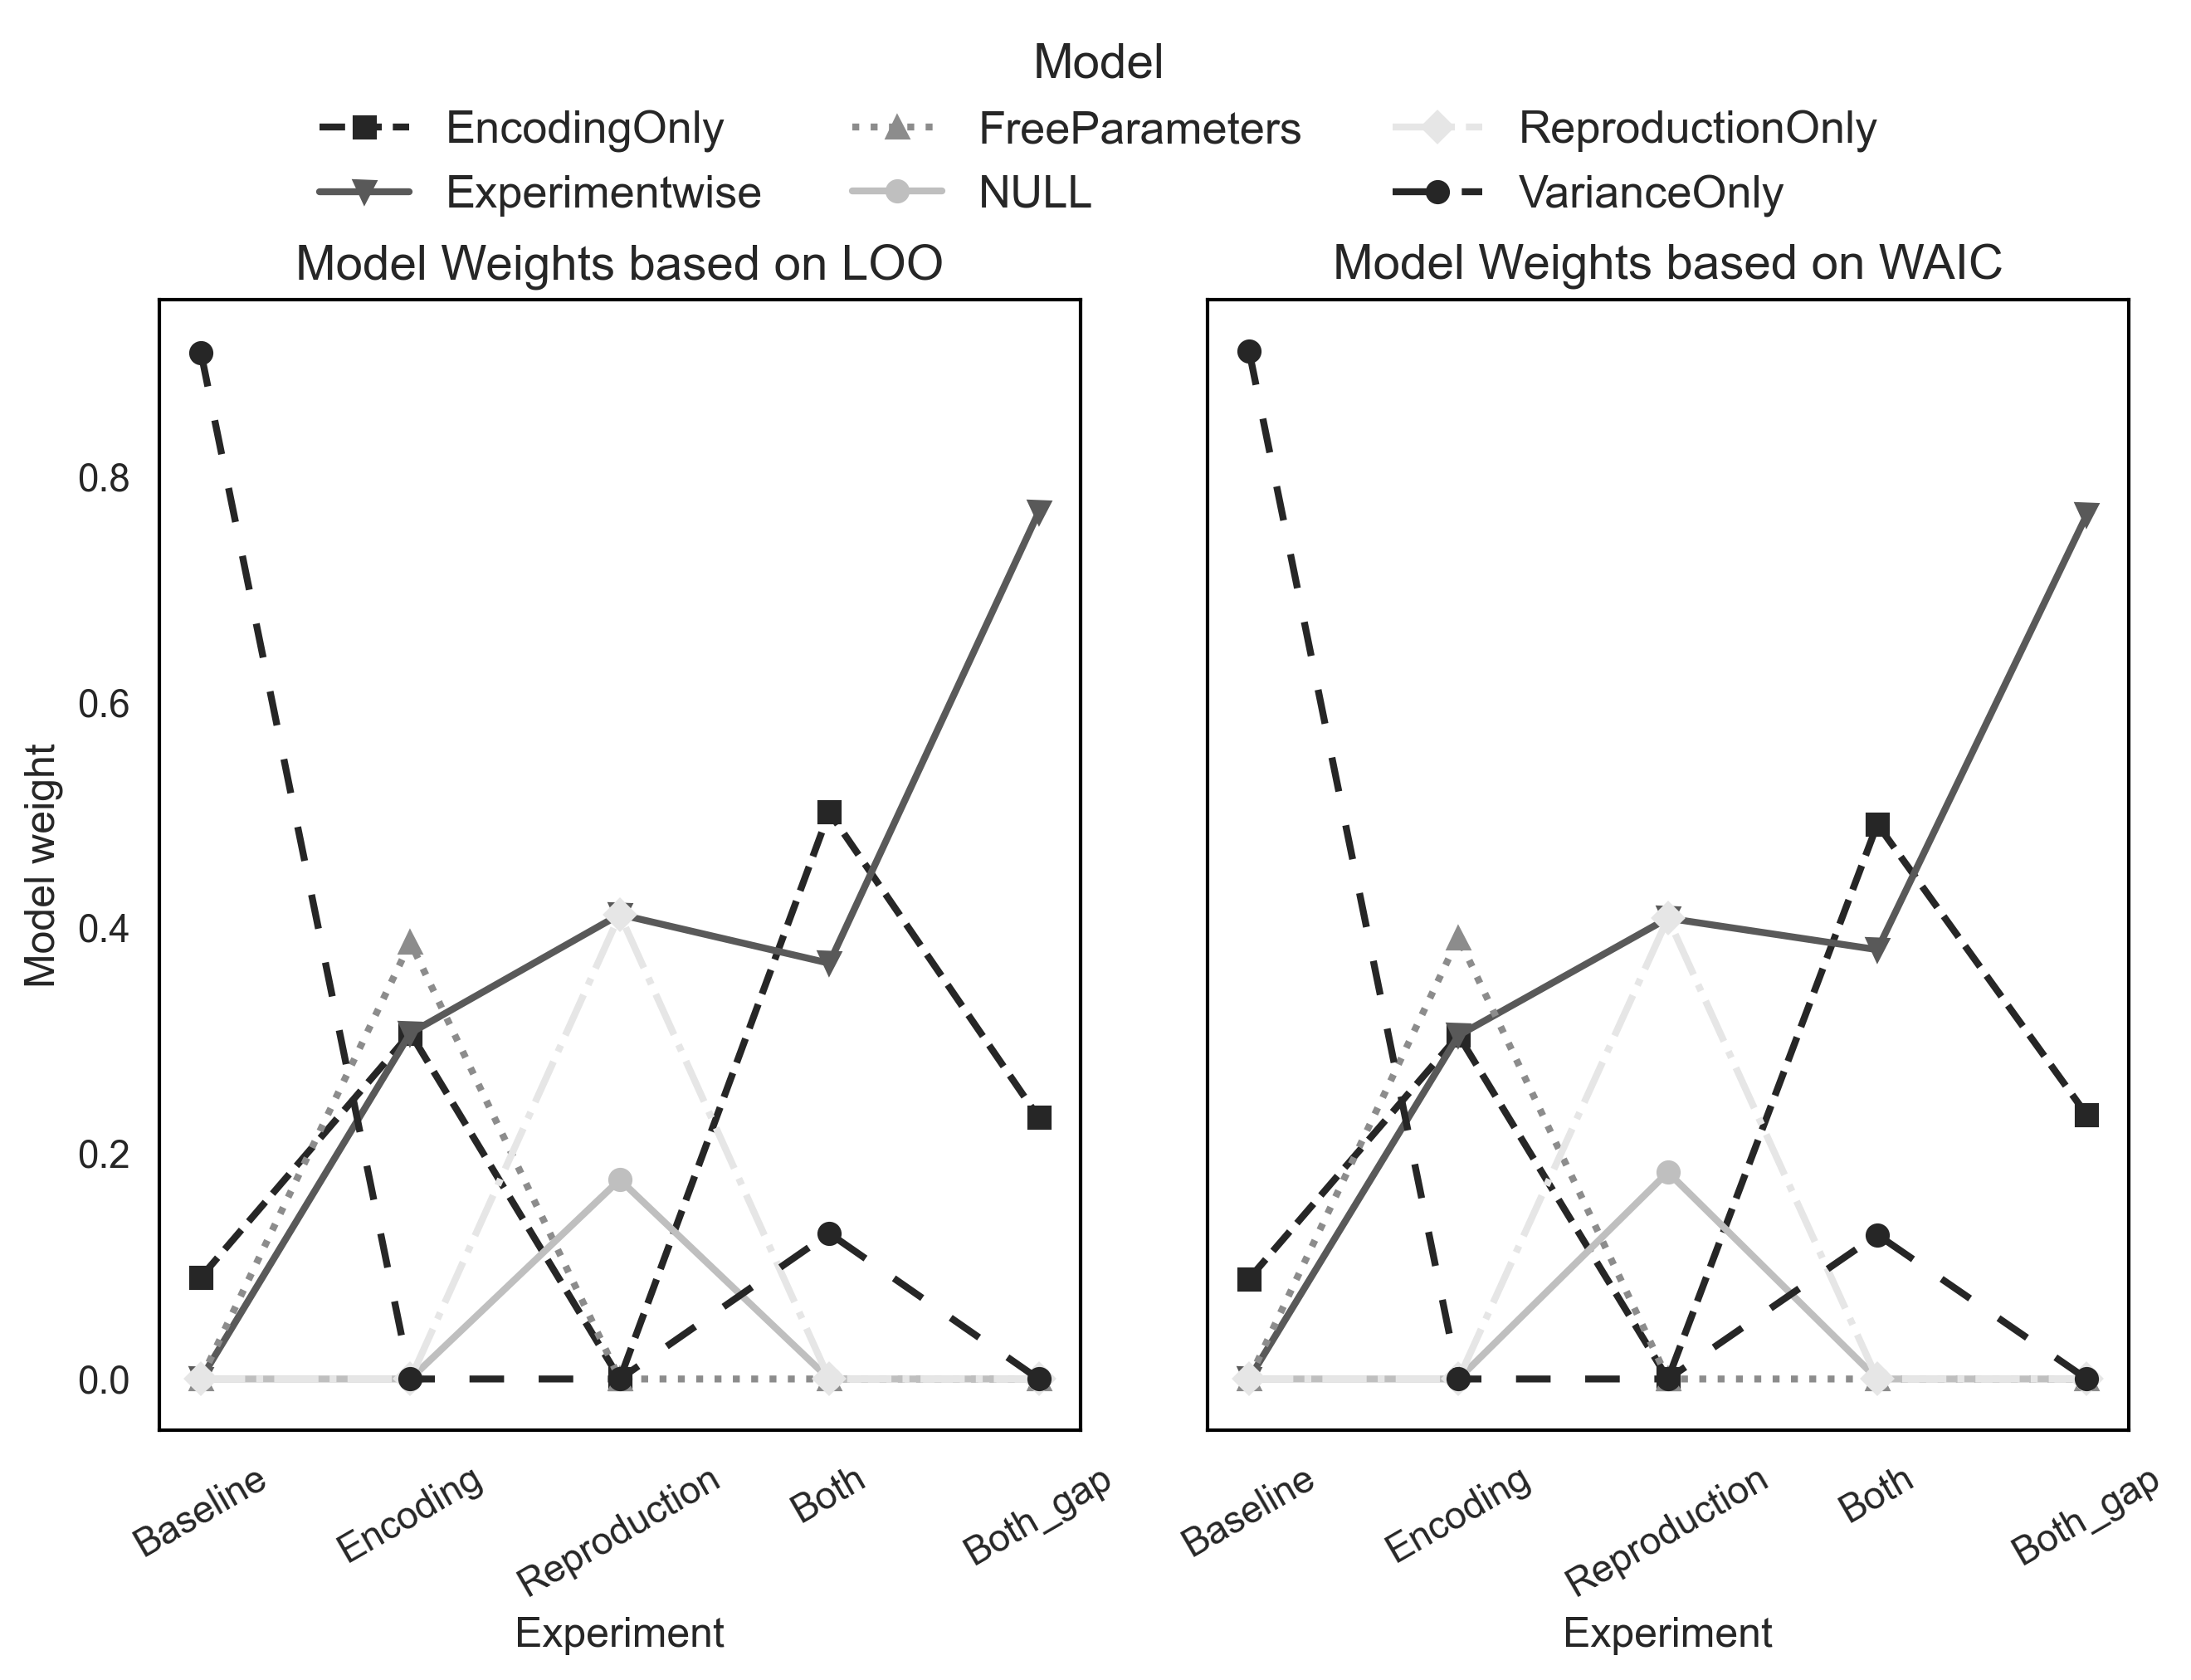

Saved figure to: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/LOO_WAIC_model_weights_combined_gray2.png


In [416]:
plot_model_weights_combined2(summary_df, OUTPUT_PATH)

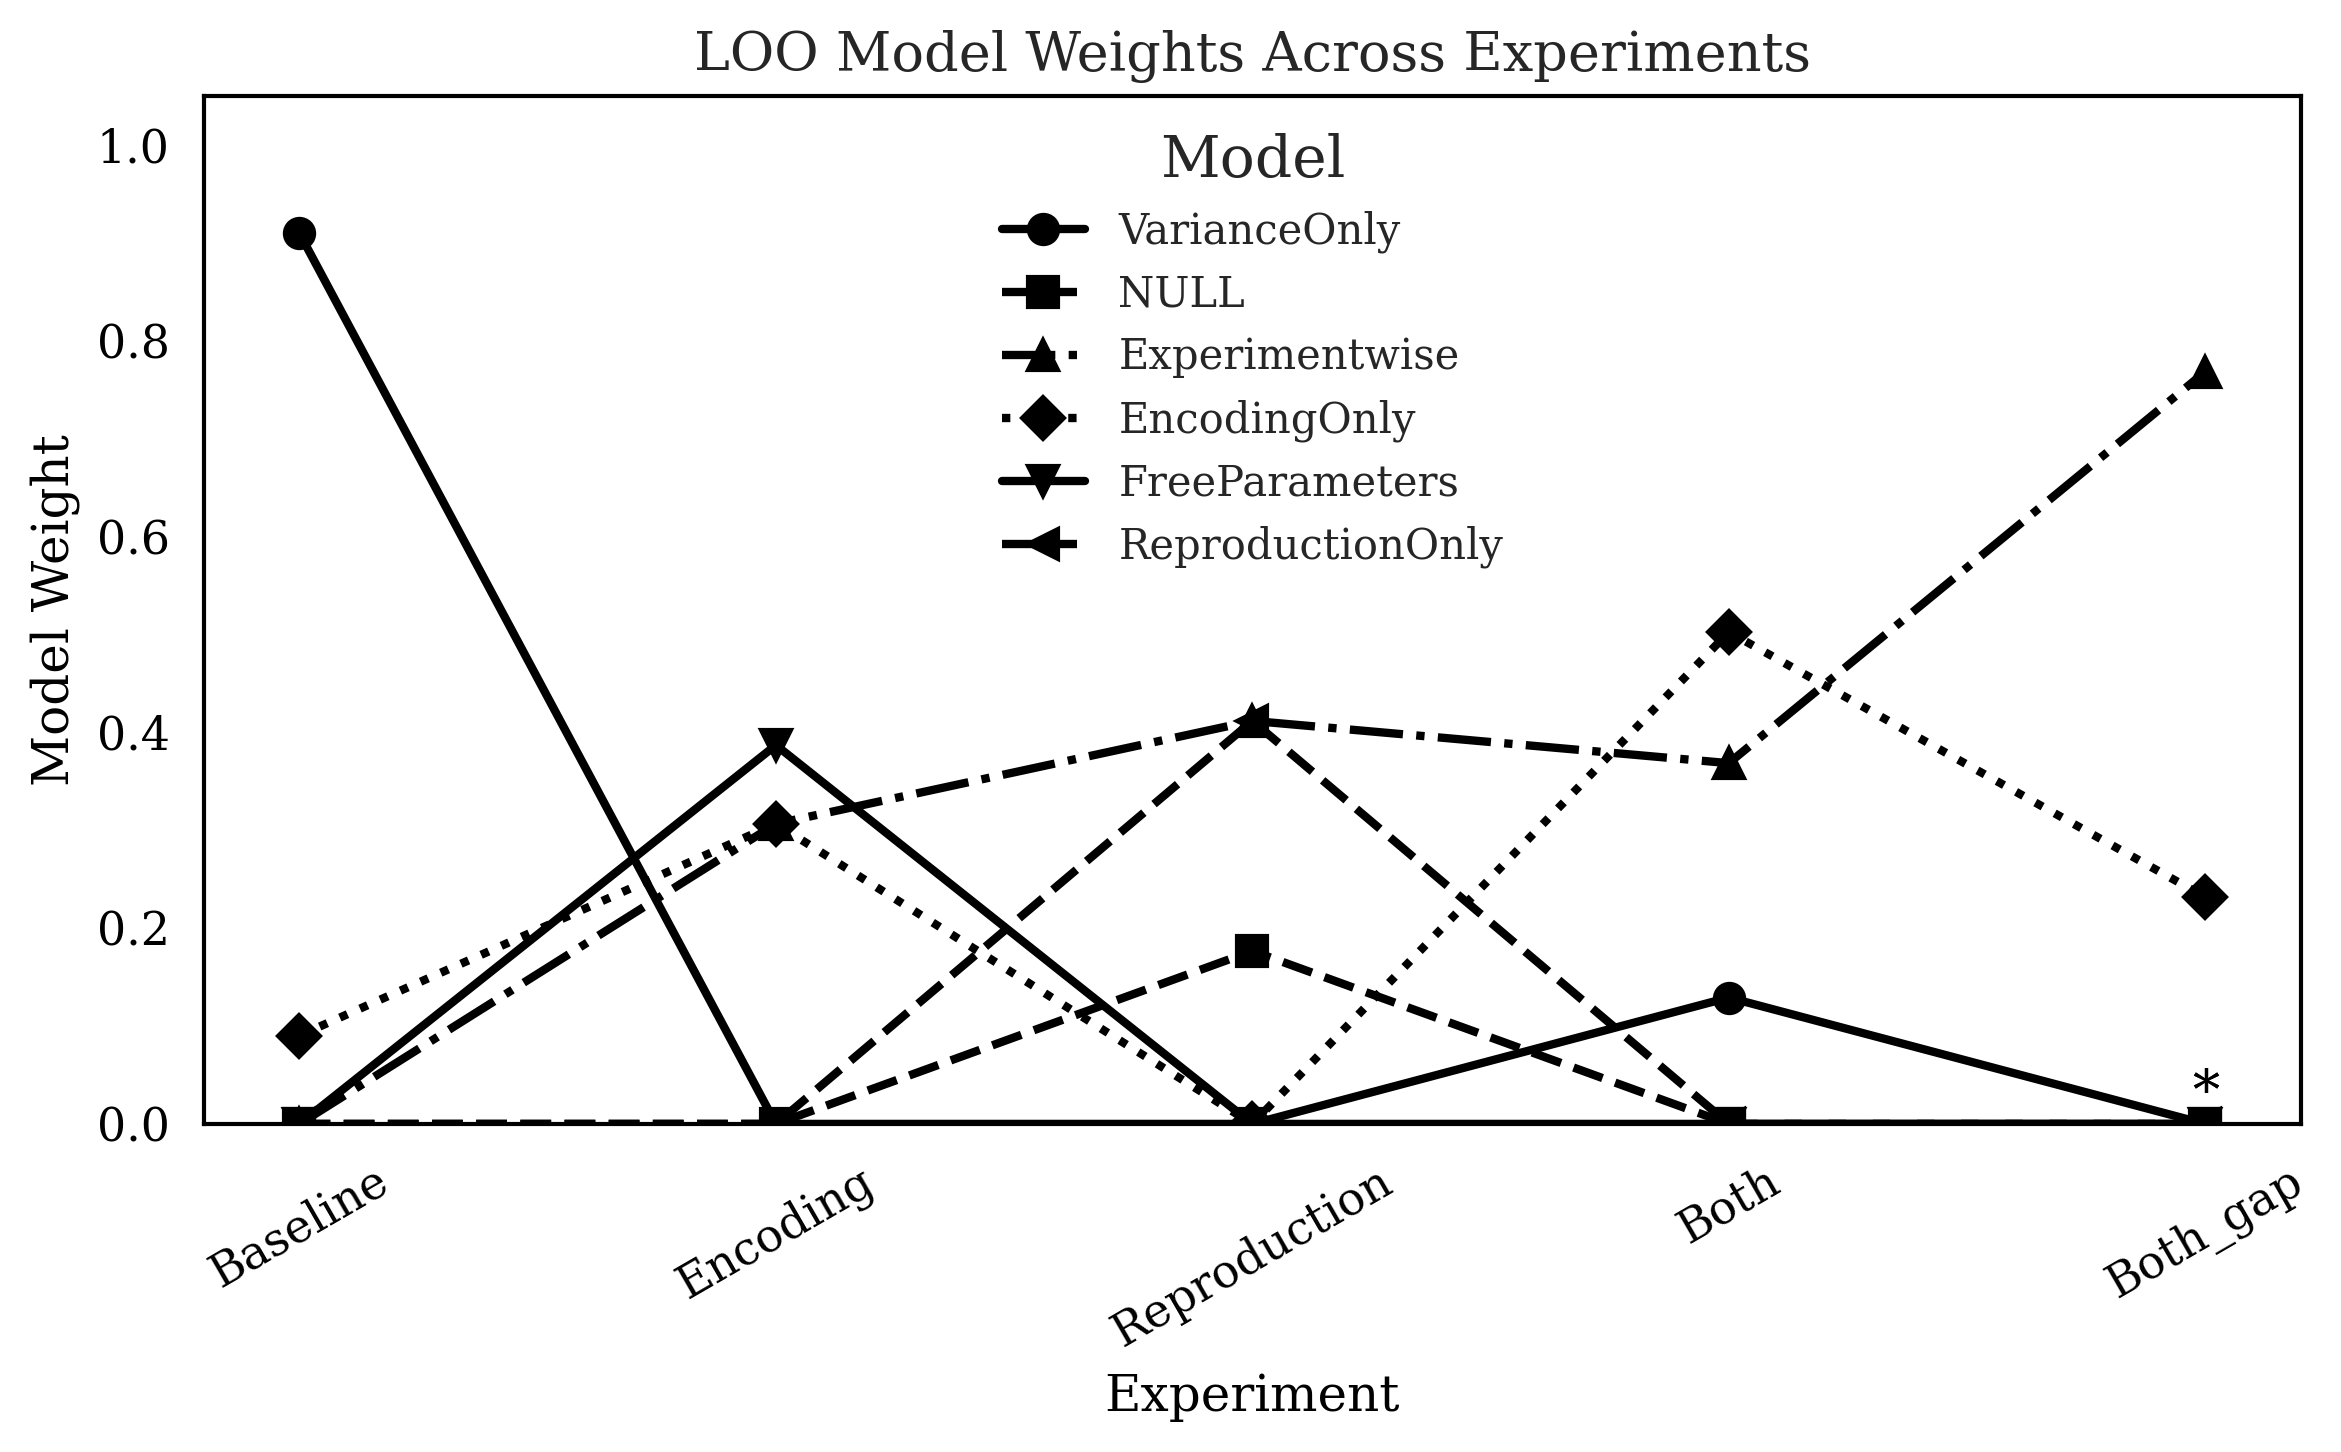

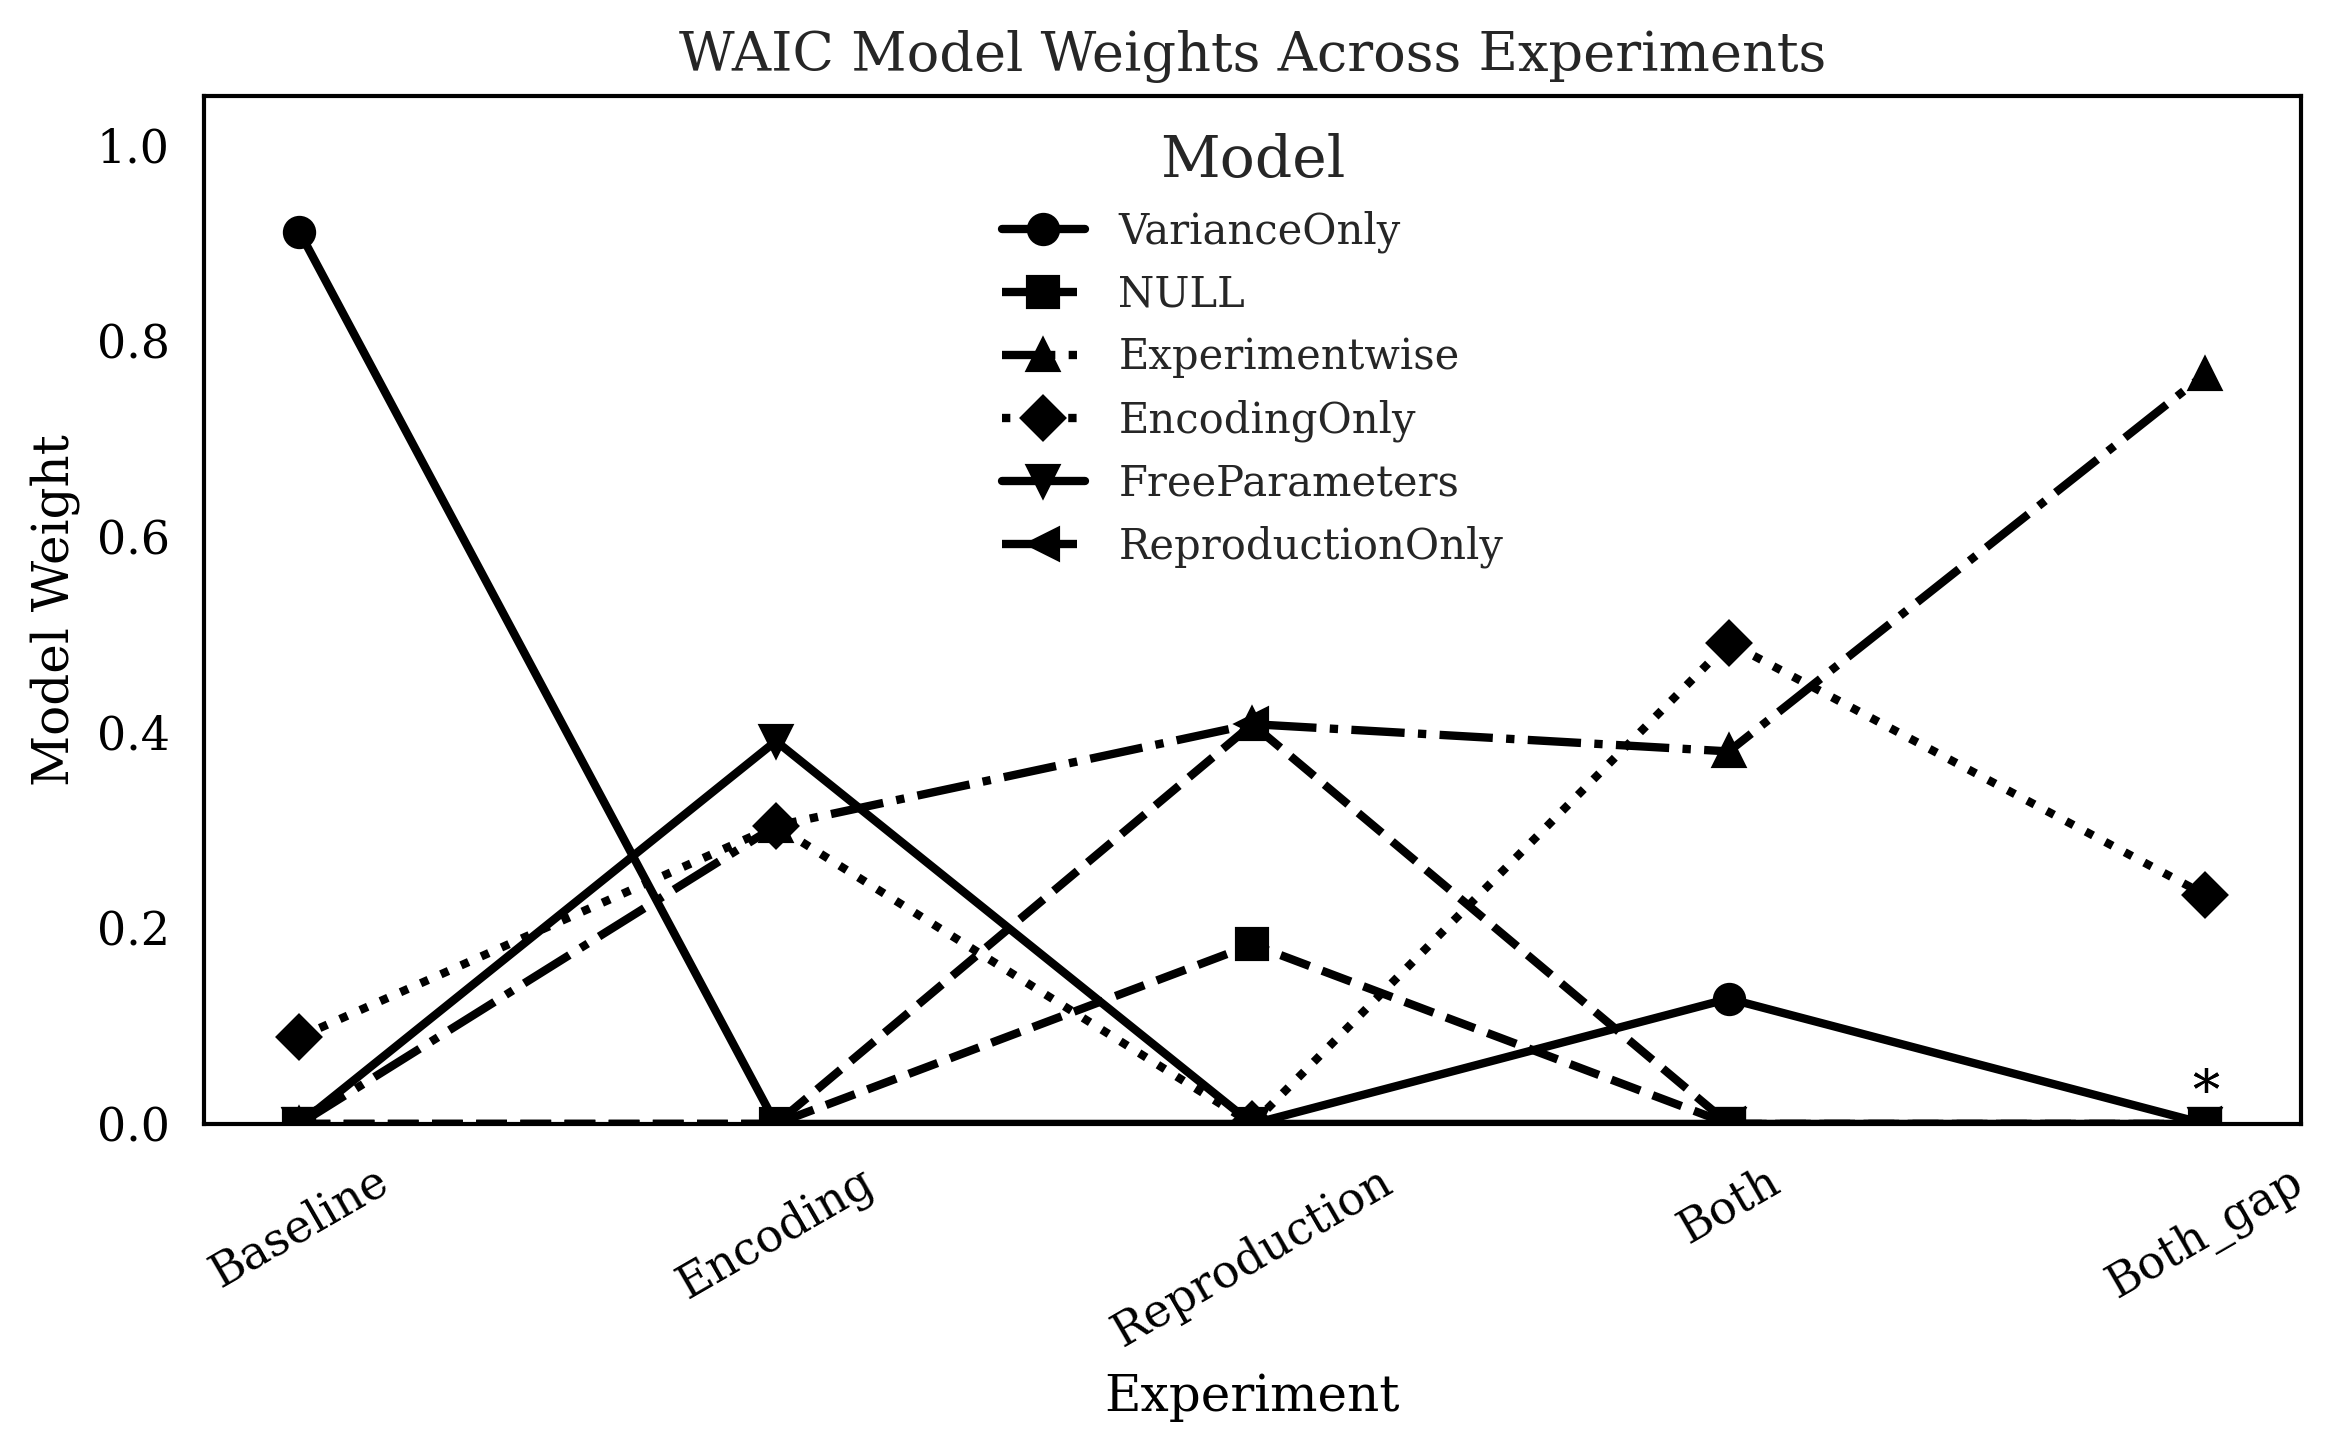

In [399]:
# ===================================================================
# Improved Academic Plot Style (Black & White)
# ===================================================================
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'legend.frameon': False,
})

line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>']

for ic in summary['ic_type'].unique():
    df = summary[summary['ic_type'] == ic]

    if 'weight' not in df.columns or df['weight'].isna().all():
        continue

    plt.figure(figsize=(8, 5))

    models = df['model_full'].unique()
    for i, model in enumerate(models):
        d = df[df['model_full'] == model]
        plt.plot(
            d['experiment'],
            d['weight'],
            linestyle=line_styles[i % len(line_styles)],
            marker=markers[i % len(markers)],
            color='black',
            label=model
        )

        # significance stars
        for _, row in d.iterrows():
            if row['significant']:
                plt.text(
                    row['experiment'],
                    row['weight'] + 0.015,
                    "*",
                    color="black",
                    fontsize=13,
                    ha="center"
                )

    plt.title(f'{ic.upper()} Model Weights Across Experiments', fontsize=13)
    plt.ylabel('Model Weight')
    plt.xlabel('Experiment')
    plt.xticks(rotation=30)
    plt.ylim(0, 1.05)
    plt.legend(title='Model', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f"{ic}_model_weights_bw.png"), dpi=300, bbox_inches='tight')
    plt.show()


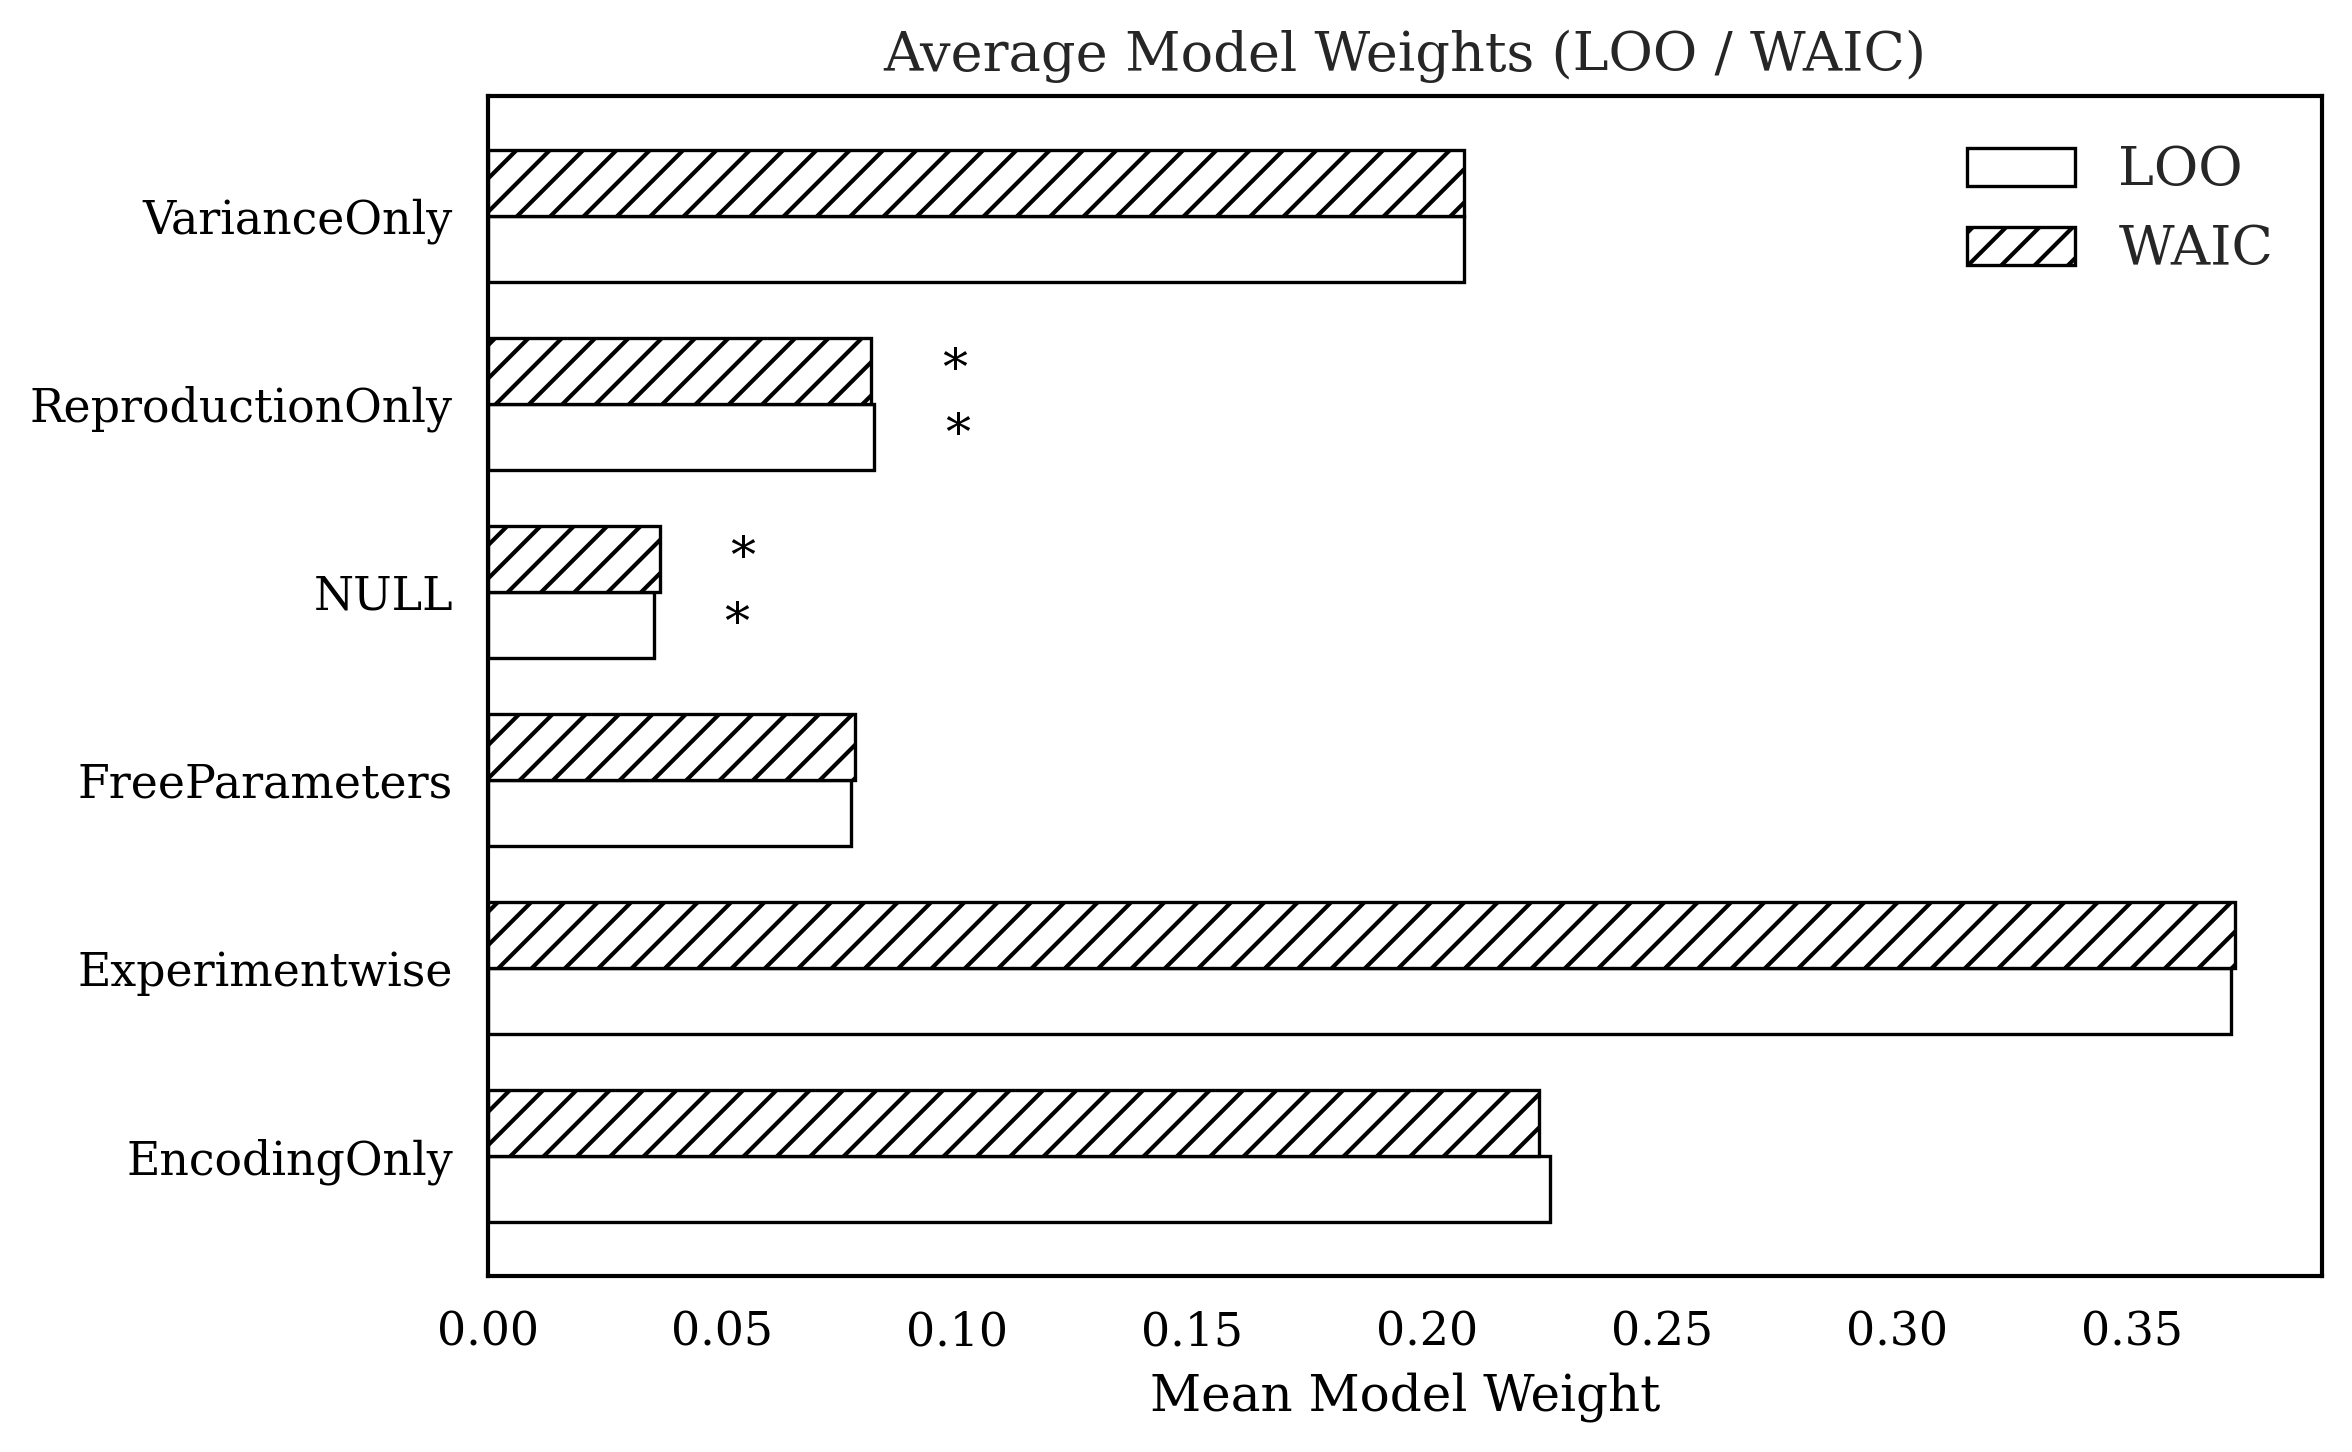

In [400]:
# ===============================
# 1. Prepare index for each model
# ===============================
models = avg['model_full'].unique()
models_sorted = sorted(models)
y_pos = np.arange(len(models_sorted))

# ===============================
# 2. Prepare figure
# ===============================
plt.figure(figsize=(8, 5))
bar_height = 0.35

# ===============================
# 3. Draw bars for LOO and WAIC
# ===============================
for j, ic in enumerate(['loo', 'waic']):
    d = avg[avg['ic_type'] == ic].set_index('model_full').loc[models_sorted]

    plt.barh(
        y_pos + j * bar_height,
        d['mean_weight'],
        height=bar_height,
        color='white',
        edgecolor='black',
        hatch='///' if ic == 'waic' else '',
        label=ic.upper()
    )

    # significance mark
    for i, (model, row) in enumerate(d.iterrows()):
        if row['significant_any']:
            plt.text(
                row['mean_weight'] + 0.015,
                y_pos[i] + j * bar_height,
                "*",
                fontsize=12,
                color='black',
                va='center'
            )

# ===============================
# 4. Formatting
# ===============================
plt.xlabel("Mean Model Weight")
plt.yticks(y_pos + bar_height / 2, models_sorted)
plt.title("Average Model Weights (LOO / WAIC)", fontsize=13)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, "average_model_weights_bw_fixed.png"),
            dpi=300, bbox_inches='tight')
plt.show()


In [401]:
def find_best_model_per_experiment(summary=None, csv_path=None, output_path="."):
    """
    从 summary DataFrame 或 CSV 中找出每个 experiment 对应 LOO / WAIC 的最优模型。
    保存结果到 best_model_per_experiment.csv
    """

    # -----------------------------
    # 1️⃣ 读取 summary
    # -----------------------------
    if summary is None:
        if csv_path is None:
            raise ValueError("必须提供 summary DataFrame 或 csv_path")
        summary = pd.read_csv(csv_path)

    # -----------------------------
    # 2️⃣ 只保留 LOO / WAIC
    # -----------------------------
    df = summary[summary['ic_type'].isin(['loo','waic'])].copy()
    if df.empty:
        raise ValueError("⚠️ 没有 LOO / WAIC 数据可供选择")

    # -----------------------------
    # 3️⃣ 找出每个 experiment 每个 ic_type 的最佳模型
    # -----------------------------
    best_records = []

    for (exp, ic), group in df.groupby(['experiment','ic_type']):
        # 对于 LOO / WAIC，最佳模型是 weight 最大的
        if 'weight' not in group.columns or group['weight'].isna().all():
            continue

        best_row = group.loc[group['weight'].idxmax()]
        best_records.append({
            'experiment': exp,
            'ic_type': ic,
            'best_model': best_row['model_full'],
            'weight': best_row['weight'],
            'elpd_diff': best_row.get('elpd_diff', None)
        })

    best_df = pd.DataFrame(best_records)

    # -----------------------------
    # 4️⃣ 保存 CSV
    # -----------------------------
    out_csv = os.path.join(output_path, "best_model_per_experiment.csv")
    best_df.to_csv(out_csv, index=False)
    print(f"✅ Best model per experiment saved: {out_csv}")
    print(best_df)

    return best_df

In [402]:
best_df = find_best_model_per_experiment(summary, OUTPUT_PATH,OUTPUT_PATH)
best_df

✅ Best model per experiment saved: /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/best_model_per_experiment.csv
     experiment ic_type        best_model    weight  elpd_diff
0      Baseline     loo      VarianceOnly  0.909718   0.000000
1      Baseline    waic      VarianceOnly  0.911189   0.000000
2          Both     loo      EncodingOnly  0.502437   0.000000
3          Both    waic      EncodingOnly  0.491652   0.324537
4      Both_gap     loo    Experimentwise  0.768315   0.000000
5      Both_gap    waic    Experimentwise  0.766036   0.000000
6      Encoding     loo    FreeParameters  0.386907   4.815137
7      Encoding    waic    FreeParameters  0.391021   4.633448
8  Reproduction     loo  ReproductionOnly  0.411667   0.000000
9  Reproduction    waic  ReproductionOnly  0.408356   0.000000


experiment ic_type        best_model    weight  elpd_diff
0      Baseline     loo      VarianceOnly  0.909718   0.000000
1      Baseline    waic      VarianceOnly  0.911189   0.000000
2          Both     loo      EncodingOnly  0.502437   0.000000
3          Both    waic      EncodingOnly  0.491652   0.324537
4      Both_gap     loo    Experimentwise  0.768315   0.000000
5      Both_gap    waic    Experimentwise  0.766036   0.000000
6      Encoding     loo    FreeParameters  0.386907   4.815137
7      Encoding    waic    FreeParameters  0.391021   4.633448
8  Reproduction     loo  ReproductionOnly  0.411667   0.000000
9  Reproduction    waic  ReproductionOnly  0.408356   0.000000

In [407]:
def compute_deltas2(all_compare_results, output_path):
    """
    1. 汇总每个实验中每个模型的 WAIC / LOO
    2. 为每个实验计算 ΔWAIC / ΔLOO
    3. 计算跨实验平均 WAIC / LOO 并计算 Δ（mean_delta 四舍五入到两位小数后再计算 avg_delta）
    4. 保存两个 CSV 文件
    """
    records = []

    # -----------------------------
    # 1️⃣ 汇总所有实验
    # -----------------------------
    for ic_type in ["loo", "waic"]:
        ic_results = all_compare_results.get(ic_type, {})

        for exp, df in ic_results.items():
            if not isinstance(df, pd.DataFrame):
                continue

            df = df.copy()
            df["experiment"] = exp
            df["ic_type"] = ic_type
            df["model"] = df.index

            # 如果没有 elpd_diff，自己计算（elpd_diff = max(elpd) - elpd）
            elpd_col = "elpd_loo" if ic_type == "loo" else "elpd_waic"
            if "elpd_diff" not in df.columns:
                df["elpd_diff"] = df[elpd_col].max() - df[elpd_col]

            records.append(df.reset_index(drop=True))

    summary = pd.concat(records, ignore_index=True)

    # -----------------------------
    # 2️⃣ 每实验 Δ
    # -----------------------------
    per_exp_records = []

    for (exp, ic), group in summary.groupby(["experiment","ic_type"]):
        group = group.copy()
        best_elpd_diff = group["elpd_diff"].min()
        group["delta"] = group["elpd_diff"] - best_elpd_diff
        per_exp_records.append(group)

    per_exp_delta = pd.concat(per_exp_records, ignore_index=True)

    # 保存每实验 Δ
    out1 = os.path.join(output_path, "per_experiment_deltas2.csv")
    per_exp_delta.to_csv(out1, index=False)
    print(f"✅ Saved per-experiment Δ LOO/WAIC → {out1}")

    # -----------------------------
    # 3️⃣ 跨实验平均 Δ
    # -----------------------------
    avg_delta_df = (
        per_exp_delta.groupby(["model","ic_type"], as_index=False)
        .agg(
            mean_elpd_diff=("elpd_diff","mean"),
            mean_delta=("delta","mean"),
            n_experiments=("experiment","nunique")
        )
    )

    # 四舍五入 mean_delta 到两位小数
    avg_delta_df["mean_delta_rounded"] = avg_delta_df["mean_delta"].round(2)

    # 找出每个 ic_type 的最佳模型（基于 mean_delta_rounded）
    avg_records = []
    for ic, group in avg_delta_df.groupby("ic_type"):
        group = group.copy()
        best_mean_delta = group["mean_delta_rounded"].min()
        group["avg_delta"] = group["mean_delta_rounded"] - best_mean_delta
        avg_records.append(group)

    avg_delta_df = pd.concat(avg_records, ignore_index=True)

    # 保存平均 Δ
    out2 = os.path.join(output_path, "average_deltas2.csv")
    avg_delta_df.to_csv(out2, index=False)
    print(f"✅ Saved average Δ LOO/WAIC → {out2}")

    return per_exp_delta, avg_delta_df


In [408]:
per_exp_delta2, avg_delta_df2 = compute_deltas2(all_compare_results, OUTPUT_PATH)

✅ Saved per-experiment Δ LOO/WAIC → /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/per_experiment_deltas2.csv
✅ Saved average Δ LOO/WAIC → /Users/fionazhu/mlabRepository/working_memory_reproduction/data/model_comparison_results/average_deltas2.csv


In [409]:
per_exp_delta2

rank     elpd_loo       p_loo   elpd_diff        weight          se  \
0      0 -2034.807001   80.069323    0.000000  9.097183e-01  157.521751   
1      1 -2029.560401   79.951495    5.246601  1.185172e-15  157.568015   
2      2 -2029.560401   79.951495    5.246601  2.229520e-15  157.568015   
3      3 -2020.564547   86.095852   14.242454  9.028173e-02  156.658586   
4      4 -2017.715221   95.155290   17.091781  2.281865e-16  157.533493   
5      5 -2010.896330   86.300667   23.910671  0.000000e+00  157.574256   
6      0          NaN         NaN    0.000000  9.111891e-01  157.430420   
7      1          NaN         NaN    4.893485  4.105548e-16  157.368344   
8      2          NaN         NaN    4.893485  0.000000e+00  157.368344   
9      3          NaN         NaN   14.299921  8.881089e-02  156.642946   
10     4          NaN         NaN   16.723639  0.000000e+00  157.448605   
11     5          NaN         NaN   23.837637  0.000000e+00  157.509227   
12     0 -1338.611024   91.421635    0.000000  5.024367e-01  156.013192   
13     1 -1338.581978   94.597952    0.029046  3.684904e-01  155.556970   
14     2 -1337.350368   95.405004    1.260656  0.000000e+00  155.672232   
15     3 -1308.438207   83.309381   30.172817  1.290729e-01  156.101770   
16     4 -1300.832798   82.802673   37.778226  0.000000e+00  155.979870   
17     5 -1277.667143   87.238484   60.943881  2.531308e-14  155.717863   
18     0          NaN         NaN    0.000000  3.804926e-01  155.383880   
19     1          NaN         NaN    0.324537  4.916518e-01  155.874242   
20     2          NaN         NaN    1.386908  3.772105e-15  155.460536   
21     3          NaN         NaN   30.191851  1.278555e-01  155.858871   
22     4          NaN         NaN   38.133908  3.378504e-15  155.853104   
23     5          NaN         NaN   61.342126  0.000000e+00  155.579205   
24     0 -8300.867760  102.149088    0.000000  7.683150e-01  281.583686   
25     1 -8298.838835  103.521318    2.028925  5.494018e-11  281.683022   
26     2 -8277.425157   97.613503   23.442603  2.316850e-01  281.758717   
27     3 -7741.393509   89.595117  559.474251  8.201920e-11  281.394785   
28     4 -7657.676570   88.187619  643.191190  4.296680e-11  281.150908   
29     5 -7656.667621   92.923590  644.200139  0.000000e+00  280.993686   
30     0          NaN         NaN    0.000000  7.660359e-01  281.621451   
31     1          NaN         NaN    1.900982  2.079691e-11  281.695666   
32     2          NaN         NaN   23.234734  2.339641e-01  281.754033   
33     3          NaN         NaN  559.177608  2.714023e-11  281.373242   
34     4          NaN         NaN  642.756627  1.394244e-11  281.107079   
35     5          NaN         NaN  643.558056  0.000000e+00  280.918864   
36     0   946.168611   69.556845    0.000000  3.065465e-01  126.771880   
37     1   946.168611   69.556845    0.000000  3.065465e-01  126.771880   
38     2   950.983748   75.471196    4.815137  3.869069e-01  127.242973   
39     3   967.534093   66.318153   21.365483  1.595769e-14  127.366683   
40     4   984.501774   65.824585   38.333164  2.540116e-15  127.212447   
41     5  1000.852029   70.794220   54.683418  0.000000e+00  127.335701   
42     0          NaN         NaN    0.000000  3.044894e-01  126.753861   
43     1          NaN         NaN    0.000000  3.044894e-01  126.753861   
44     2          NaN         NaN    4.633448  3.910212e-01  127.208068   
45     3          NaN         NaN   21.255401  3.769668e-14  127.329315   
46     4          NaN         NaN   38.444801  0.000000e+00  127.204846   
47     5          NaN         NaN   54.545871  0.000000e+00  127.301084   
48     0 -1243.014881   87.915463    0.000000  4.116674e-01  141.456381   
49     1 -1243.014881   87.915463    0.000000  4.116674e-01  141.456381   
50     2 -1240.440381   90.626986    2.574501  0.000000e+00  141.519968   
51     3 -1193.414350   77.010328   49.600531  1.766653e-01  141.464593   
52     4 -1162.599982   81.23

In [410]:
avg_delta_df2

model ic_type  mean_elpd_diff  mean_delta  n_experiments  \
0       EncodingOnly     loo       23.619991   23.619991              5   
1     Experimentwise     loo        1.055129    1.055129              5   
2     FreeParameters     loo        5.554200    5.554200              5   
3               NULL     loo      154.829942  154.829942              5   
4   ReproductionOnly     loo      156.747622  156.747622              5   
5       VarianceOnly     loo      149.012696  149.012696              5   
6       EncodingOnly    waic       23.497603   23.497603              5   
7     Experimentwise    waic        0.978697    0.978697              5   
8     FreeParameters    waic        5.272809    5.272809              5   
9               NULL    waic      154.530209  154.530209              5   
10  ReproductionOnly    waic      156.656738  156.656738              5   
11      VarianceOnly    waic      148.388749  148.388749              5   

    mean_delta_rounded  avg_delta  
0                23.62      22.56  
1                 1.06       0.00  
2                 5.55       4.49  
3               154.83     153.77  
4               156.75     155.69  
5               149.01     147.95  
6                23.50      22.52  
7                 0.98       0.00  
8                 5.27       4.29  
9               154.53     153.55  
10              156.66     155.68  
11              148.39     147.41

In [285]:
def unified_model_ranking(all_compare_results, output_path):
    """
    Unified procedure to rank models:
      - Pooled ELPD: sum elpd per model across experiments (per IC type: loo / waic)
      - pooled_delta = pooled_elpd_best - pooled_elpd_model (so best has 0)
      - pooled_weight = softmax(-0.5 * pooled_delta)
      - avg_weight = average of per-experiment weights (computed per-experiment from ΔIC)
    Saves:
      - pooled_results_<ic>.csv
      - per_experiment_weights_<ic>.csv
      - unified_summary_<ic>.csv
    Returns: dict of DataFrames
    """
    os.makedirs(output_path, exist_ok=True)
    results = {}

    for ic in ['loo', 'waic']:
        ic_dict = all_compare_results.get(ic, {})
        # 1) build per-experiment table if possible
        per_exp_dfs = []
        for exp, df in ic_dict.items():
            if not isinstance(df, pd.DataFrame) or df.empty:
                continue
            tmp = df.copy()
            tmp = tmp.reset_index().rename(columns={'index':'model_full'})
            tmp['experiment'] = exp
            # choose elpd column name
            elpd_col = 'elpd_loo' if ic == 'loo' else 'elpd_waic'
            if elpd_col not in tmp.columns:
                # sometimes az.compare returns 'elpd' or other naming; try generic matches
                possible = [c for c in tmp.columns if c.lower().startswith('elpd')]
                if possible:
                    elpd_col = possible[0]
                else:
                    raise ValueError(f"Cannot find elpd column for ic={ic} in experiment {exp}")
            tmp['elpd'] = tmp[elpd_col]
            per_exp_dfs.append(tmp[['experiment','model_full','elpd','elpd_diff','weight']].copy())

        if not per_exp_dfs:
            print(f"No data for ic={ic}")
            continue

        per_exp_all = pd.concat(per_exp_dfs, ignore_index=True, sort=False)

        # 2) compute per-experiment ΔIC (using elpd_diff if present; otherwise compute from elpd)
        def compute_per_exp_weights(df_exp):
            # df_exp: subset for one experiment
            out = df_exp.copy()
            if 'elpd_diff' in out.columns and out['elpd_diff'].notna().any():
                # elpd_diff usually defined as best_elpd - model_elpd (so best -> 0)
                out['delta_elpd'] = out['elpd_diff']
            else:
                # compute delta relative to best (max elpd)
                out['delta_elpd'] = out['elpd'].max() - out['elpd']
            # convert to delta IC-like: d_ic = -2 * elpd_diff  (but weights using elpd_diff directly via exp(-0.5 * d_ic))
            out['d_ic'] = -2.0 * out['delta_elpd']  # note: smaller d_ic better; d_ic(best)=0 if delta_elpd=0
            # compute weights: using formula w = exp(-0.5 * d_ic) / sum(...)
            # substituting d_ic gives exp(-0.5 * d_ic) = exp(-0.5 * (-2 * delta_elpd)) = exp(delta_elpd)
            # to preserve usual transformation we will compute using d_ic robustly:
            w_raw = np.exp(-0.5 * out['d_ic'].fillna(0).astype(float))
            out['weight_from_delta'] = w_raw / w_raw.sum()
            return out

        per_exp_weights = per_exp_all.groupby('experiment', group_keys=False).apply(compute_per_exp_weights).reset_index(drop=True)

        # 3) pooled elpd per model: sum elpd across experiments
        pooled = per_exp_all.groupby('model_full', as_index=False).agg(
            pooled_elpd=('elpd','sum'),
            n_experiments=('experiment','nunique')
        )

        # set best pooled_elpd and compute pooled_delta (best - model) so best -> 0 if using delta_elpd definition
        best_pooled_elpd = pooled['pooled_elpd'].max()
        pooled['pooled_delta_elpd'] = best_pooled_elpd - pooled['pooled_elpd']   # >=0, best -> 0
        # convert to pooled d_ic for weights: d_ic = -2 * delta_elpd
        pooled['pooled_d_ic'] = -2.0 * pooled['pooled_delta_elpd']
        # pooled weight
        w_raw = np.exp(-0.5 * pooled['pooled_d_ic'].astype(float))
        pooled['pooled_weight'] = w_raw / w_raw.sum()

        # 4) average per-experiment weight (stability measure): for each model, mean weight_from_delta across exps
        avg_weights = per_exp_weights.groupby('model_full', as_index=False).agg(
            avg_weight=('weight_from_delta','mean'),
            median_weight=('weight_from_delta','median')
        )

        # 5) merge pooled and avg
        unified = pooled.merge(avg_weights, on='model_full', how='left')

        # 6) ranking and choose best by pooled_delta_elpd (i.e., smallest pooled_delta_elpd -> best)
        unified = unified.sort_values('pooled_delta_elpd', ascending=True).reset_index(drop=True)
        unified['pooled_rank'] = np.arange(1, len(unified)+1)
        # also rank by avg_weight
        unified = unified.sort_values(['pooled_rank'], ascending=True).reset_index(drop=True)

        # 7) Save outputs
        pooled_out = os.path.join(output_path, f'pooled_results_{ic}.csv')
        perexp_out = os.path.join(output_path, f'per_experiment_weights_{ic}.csv')
        unified_out = os.path.join(output_path, f'unified_summary_{ic}.csv')

        pooled.to_csv(pooled_out, index=False)
        per_exp_weights.to_csv(perexp_out, index=False)
        unified.to_csv(unified_out, index=False)

        print(f"[{ic}] saved: {pooled_out}, {perexp_out}, {unified_out}")

        results[ic] = {
            'pooled': pooled,
            'per_experiment_weights': per_exp_weights,
            'unified': unified
        }

    return results

In [ ]:
unified_result = unified_model_ranking(all_compare_results, OUTPUT_PATH)
unified_result

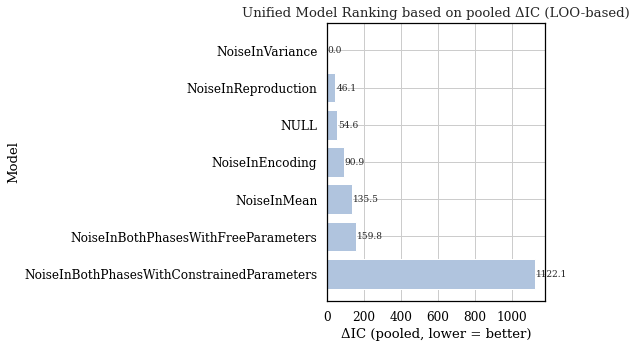

Best model: NoiseInVariance


In [66]:
# 假设 unified_result 是你完整返回的结果字典
unified_df = unified_result['loo']['unified'].copy()  # 或 'waic'['unified']
unified_df = unified_df.sort_values('pooled_delta_elpd', ascending=True)

# 绘图
plt.figure(figsize=(8, 5))
bars = plt.barh(unified_df['model_full'], unified_df['pooled_delta_elpd'], color='lightsteelblue')

# 标记最佳模型（最小 ΔIC）
best_model_idx = unified_df['pooled_delta_elpd'].idxmin()
bars[list(unified_df.index).index(best_model_idx)].set_color('seagreen')

# 添加文本标签
for i, (val, model) in enumerate(zip(unified_df['pooled_delta_elpd'], unified_df['model_full'])):
    plt.text(val + 5, i, f"{val:.1f}", va='center', fontsize=9)

plt.xlabel("ΔIC (pooled, lower = better)")
plt.ylabel("Model")
plt.title("Unified Model Ranking based on pooled ΔIC (LOO-based)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Best model:", unified_df.loc[best_model_idx, 'model_full'])

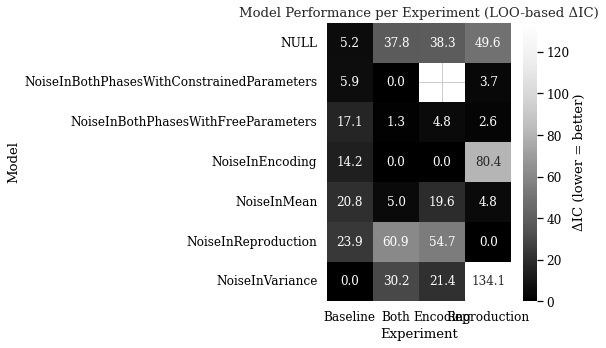

In [67]:
# 假设 unified_result 中有按实验计算的 elpd_diff 或 delta 值
# unified_result['loo']['per_experiment_weights'] → 每个模型每个实验的ΔIC
by_exp = unified_result['loo']['per_experiment_weights'].copy()  # 或 waic
pivot_df = by_exp.pivot(index='model_full', columns='experiment', values='delta_elpd')

plt.figure(figsize=(8, 5))
sns.heatmap(
    pivot_df,
    cmap='Greys_r',  # 黑白配色, 浅色 = 更好
    annot=True, fmt=".1f",
    cbar_kws={'label': 'ΔIC (lower = better)'}
)
plt.title("Model Performance per Experiment (LOO-based ΔIC)")
plt.ylabel("Model")
plt.xlabel("Experiment")
plt.tight_layout()
plt.show()

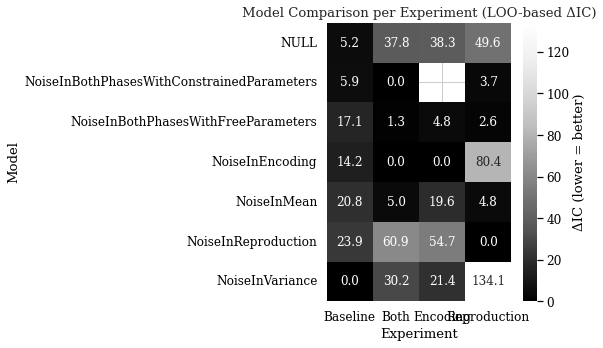

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# 只保留LOO或WAIC中的一个（推荐LOO）
df = summary[summary['ic_type'] == 'loo'].copy()

# 为防止排序乱，确保 experiment 排序
df['experiment'] = df['experiment'].astype(str)
pivot = df.pivot(index='model_full', columns='experiment', values='elpd_diff')

plt.figure(figsize=(8, 5))
sns.heatmap(
    pivot,
    cmap='Greys_r',    # 黑白风格，越浅表示ΔIC越小（拟合越好）
    annot=True,
    fmt=".1f",
    cbar_kws={'label': 'ΔIC (lower = better)'}
)
plt.title("Model Comparison per Experiment (LOO-based ΔIC)")
plt.ylabel("Model")
plt.xlabel("Experiment")
plt.tight_layout()
plt.show()
